In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle_hm.utils import init_nb
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.image as mpimg

init_nb()

In [2]:
customers = pd.read_parquet('../data/clean/customers.parquet')
items = pd.read_parquet('../data/clean/articles.parquet')
t = pd.read_parquet('../data/clean/transactions.parquet')
t_ext = t.merge(items[['article_id', 'prod_name', 'product_group_name', 'perceived_colour_master_name', 'index_name', 'product_type_name']])
t_ext['dow'] = t_ext['t_dat'].dt.dayofweek.map({0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"})

season_map = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
t_ext['season'] = t_ext['t_dat'].dt.month.map(season_map)

In [3]:
sample = customers.sample(n=1000, random_state=1)
t_sample = t[t['customer_id'].isin(sample['customer_id'])]

In [291]:
customer = sample.iloc[3]['customer_id']

print(sample.iloc[3])

t_sample[t_sample['customer_id'] == customer][['t_dat', 'dow', 'price', 'article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name', 'perceived_colour_master_name', 'sales_channel_id']].sort_values('t_dat')

customer_id               bb455bc38400bd6902f9bea828df555a3d55818fcb144b...
FN                                                                    1.000
Active                                                                1.000
club_member_status                                                   ACTIVE
fashion_news_frequency                                            Regularly
age                                                                  54.000
postal_code               1d98a184bc258bf41ea61b66cdcc46bc5c05c2d982c38e...
Name: 1003611, dtype: object


t_dat  dow  price  article_id                  prod_name  \
3290  2020-05-18  Mon  0.017   688558001                Brittany LS   
3291  2020-05-18  Mon  0.017   688558001                Brittany LS   
4261  2020-05-18  Mon  0.034   706016002   Jade HW Skinny Denim TRS   
19090 2020-05-18  Mon  0.012   800691008       Claudine rib t-shirt   
20659 2020-05-18  Mon  0.025   806225009  All That Jazz Push Up Bra   
22158 2020-08-12  Wed  0.042   852585002          Tinos mesh tights   
22165 2020-08-12  Wed  0.042   730683050           HAVANA HW tights   

      product_type_name  product_group_name        index_name  \
3290                Top  Garment Upper body           Divided   
3291                Top  Garment Upper body           Divided   
4261           Trousers  Garment Lower body           Divided   
19090           T-shirt  Garment Upper body        Ladieswear   
20659        Bikini top            Swimwear  Lingeries/Tights   
22158   Leggings/Tights  Garment Lower body             Sport   
22165           Unknown             Unknown             Sport   

      perceived_colour_master_name  sales_channel_id  
3290                         Black                 2  
3291                         Black                 2  
4261                          Blue                 2  
19090                        Black                 2  
20659                        White                 2  
22158                        Black                 2  
22165                        Black                 2

Let's explore basic characteristics of sales

In [6]:
t_ext.shape

(23715, 11)

In [13]:
t_ext['product_type_name'].value_counts(normalize=True) * 100

Trousers              13.591
Dress                  9.534
Sweater                9.382
T-shirt                6.882
Top                    5.246
                       ...  
Shoulder bag           0.000
Side table             0.000
Sleeping sack          0.000
Stain remover spray    0.000
Zipper head            0.000
Name: product_type_name, Length: 131, dtype: float64

In [7]:
t_ext['product_type_name'].value_counts(normalize=True)[:20].sum()

0.8693232131562303

To keep charts readable let's limit data to top-20 products, they account for 87% of items sold.

In [8]:
top_prods = set(t_ext['product_type_name'].value_counts()[:20].index)
top_t = t_ext[t_ext['product_type_name'].isin(top_prods)]

In [259]:
items['product_type_name'].value_counts(normalize=True)[:20]

Trousers           0.106
Dress              0.098
Sweater            0.088
T-shirt            0.075
Top                0.039
Blouse             0.038
Jacket             0.037
Shorts             0.037
Shirt              0.032
Vest top           0.028
Underwear bottom   0.026
Skirt              0.026
Hoodie             0.022
Bra                0.021
Socks              0.018
Leggings/Tights    0.018
Sneakers           0.015
Cardigan           0.015
Hat/beanie         0.013
Garment Set        0.013
Name: product_type_name, dtype: float64

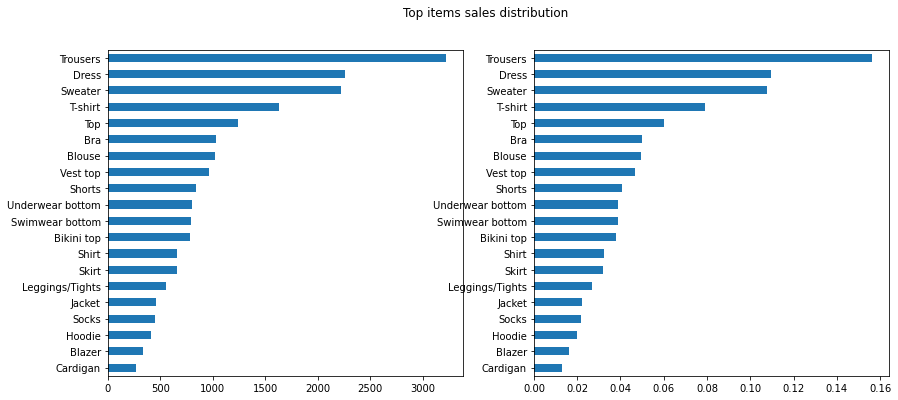

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

top_t['product_type_name'].value_counts().sort_values().plot.barh(ax=ax[0])
top_t['product_type_name'].value_counts(normalize=True).sort_values().plot.barh(ax=ax[1])

plt.suptitle('Top items sales distribution');

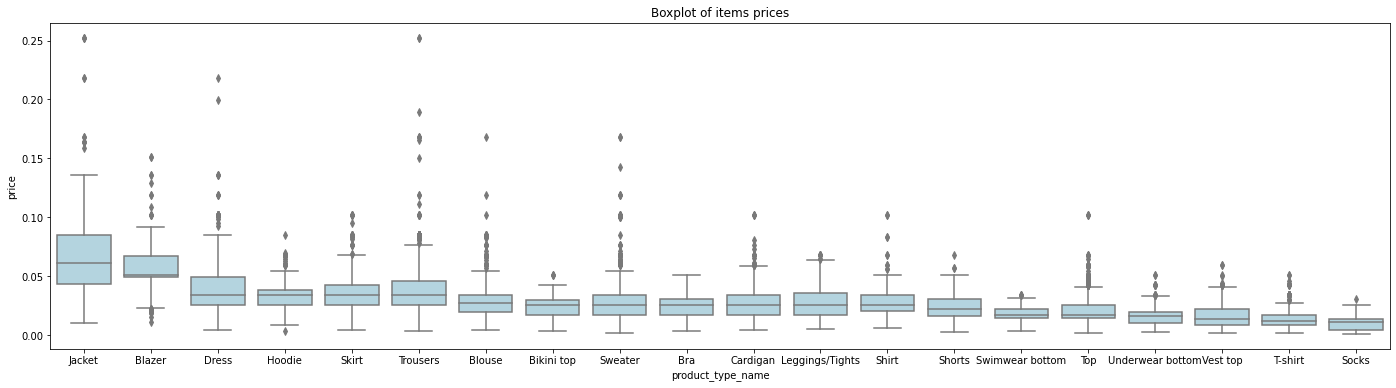

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))
_ = list(top_t.groupby('product_type_name')['price'].median().sort_values(ascending=False).index)
sns.boxplot(data=top_t, x='product_type_name', y='price', order=_, color='lightblue')
ax.set(title='Boxplot of items prices');

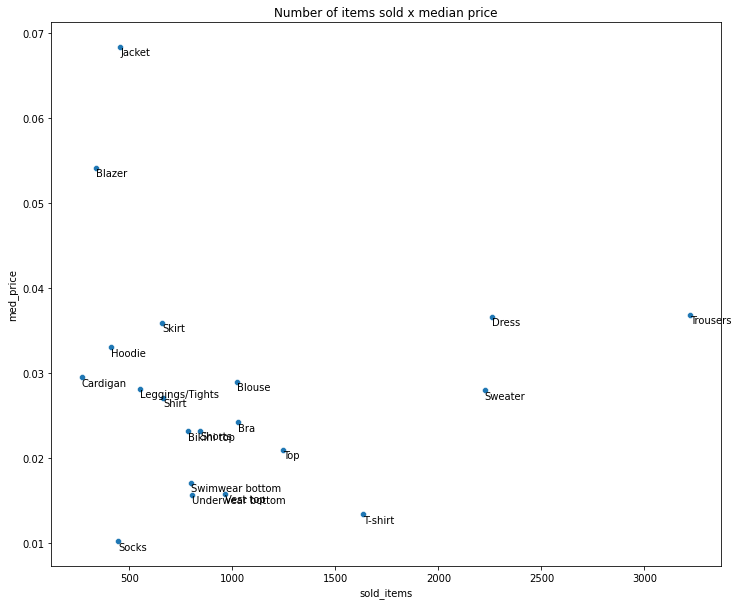

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
_ = top_t.groupby('product_type_name').agg(sold_items=('article_id', 'count'), med_price=('price', 'mean'))

sns.scatterplot(data=_, x='sold_items', y='med_price', ax=ax)

for line in range(0, _.shape[0]):
     ax.text(_.iloc[line]['sold_items']+0.2, _.iloc[line]['med_price']-.001, _.iloc[line].name, horizontalalignment='left', size='medium', color='black')
plt.title('Number of items sold x median price');

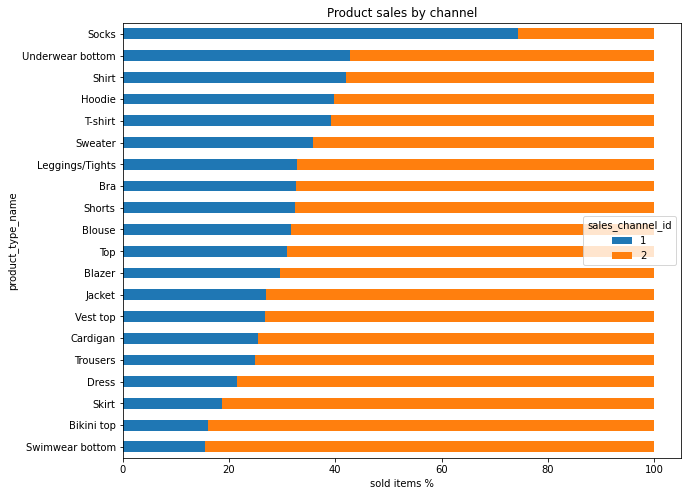

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
(pd.crosstab(
    top_t['product_type_name'],
    top_t['sales_channel_id'],
    top_t['article_id'],
    aggfunc='count',
    normalize='index'
).sort_values(1) * 100).plot.barh(ax=ax, stacked=True)

ax.set(title='Product sales by channel', xlabel='sold items %');

Customers are more likely to buy socks in the brick shop? :D

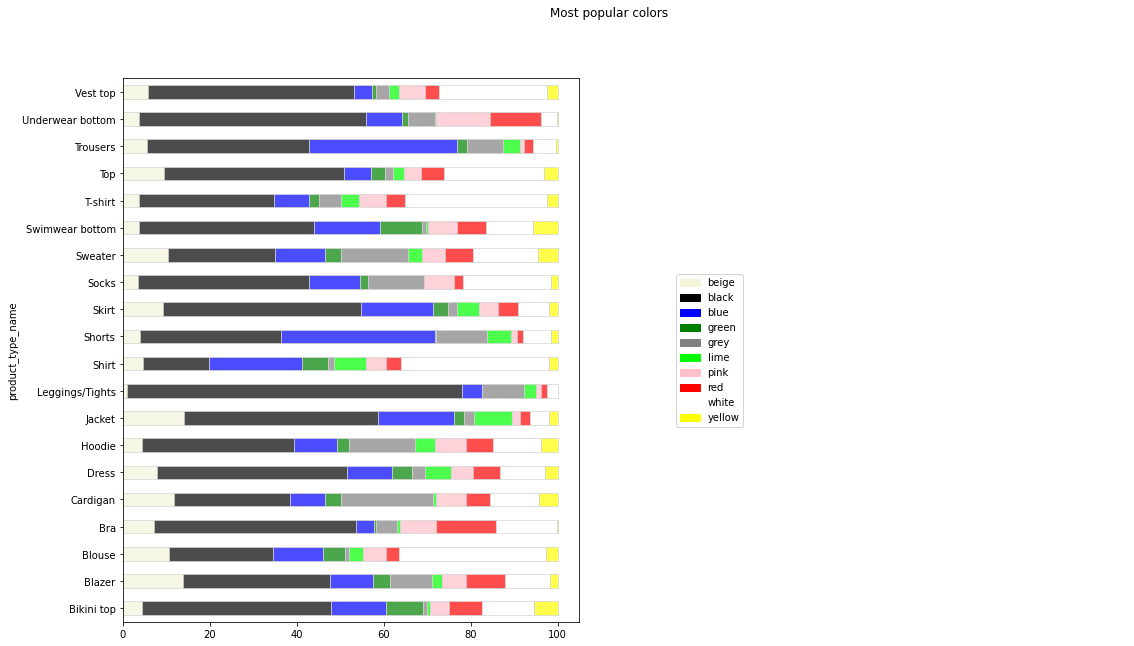

In [96]:
top_colors = (
    top_t['perceived_colour_master_name'].value_counts().sort_values(ascending=False)[:10]
)

top_colors = set(top_colors.index)

_ = top_t[top_t['perceived_colour_master_name'].isin(top_colors)]
ct = pd.crosstab(
    _['product_type_name'],
    _['perceived_colour_master_name'],
    normalize='index'
) * 100

colors = pd.Series(ct.columns).replace({'Khaki green': 'lime'}).str.lower()
fig, ax = plt.subplots(1, 2, figsize=(18, 10))

p = [mpatches.Patch(color=_, label=_) for _ in colors.values]

ax[1].legend(handles=p, loc='center left')
ax[1].axis('off')
ct.plot.barh(stacked=True, color=colors.values, edgecolor='lightgray', legend=False, ax=ax[0], alpha=.7)
fig.suptitle('Most popular colors');

- most of sold leggings / tights are black
- red/pink underwear
- blue trousers and shorts
- top gray item is hoodie/cardigan

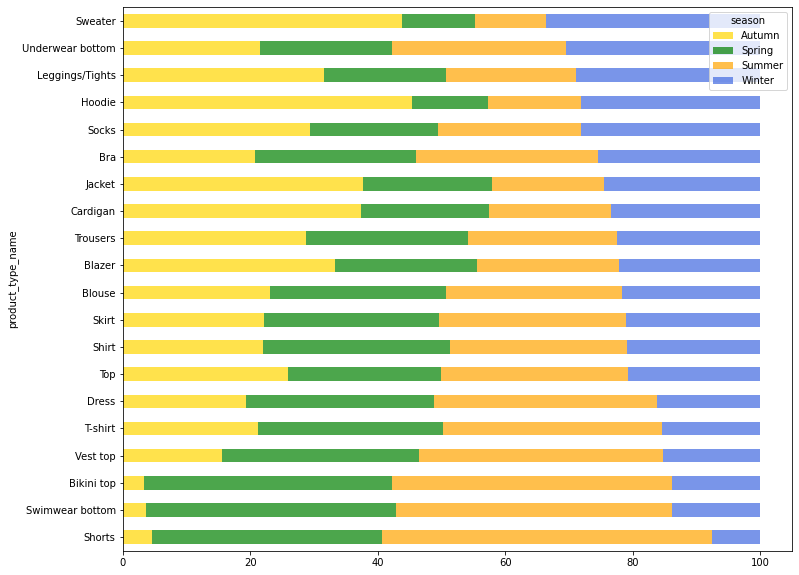

In [104]:
_ = pd.crosstab(top_t['product_type_name'], top_t['season'], normalize='index') * 100
_.sort_values('Winter', ascending=True).plot.barh(figsize=(12, 10), stacked=True, color=['gold', 'green', 'orange', 'royalblue'], alpha=.7);

No surprises here, warm cloths are sold in more cold seasons, and bikini/shorts are sold when it's warm

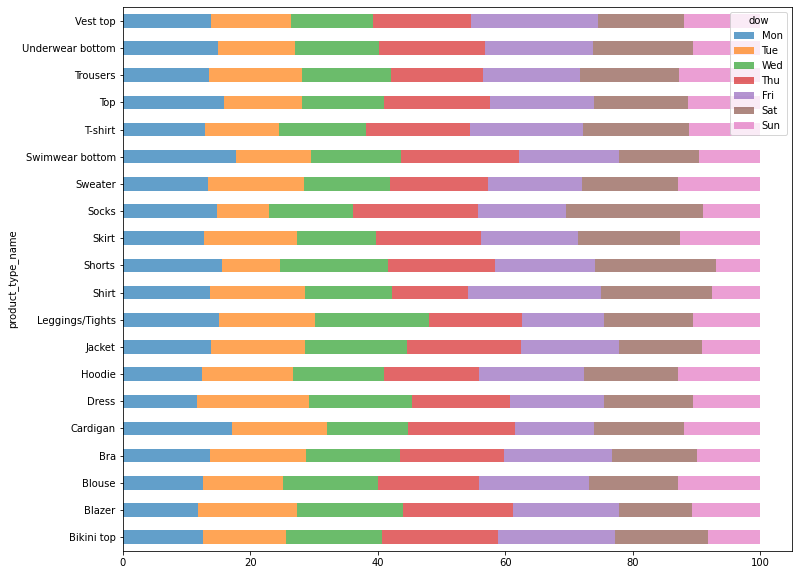

In [292]:
_ = pd.crosstab(top_t['product_type_name'], top_t['dow'], normalize='index') * 100
_[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].plot.barh(stacked=True, figsize=(12, 10), alpha=.7);

<AxesSubplot:>

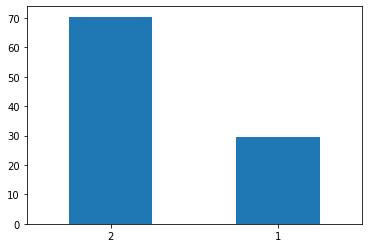

In [4]:
(t_ext['sales_channel_id'].value_counts(normalize=True) * 100).plot.bar(rot=0)

<AxesSubplot:>

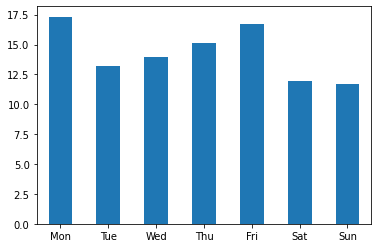

In [60]:
(t_ext['dow'].value_counts(normalize=True) * 100).loc[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].plot.bar(rot=0)

In [46]:
t_ext['perceived_colour_master_name'].value_counts(normalize=True) * 100

Black          41.163
Blue           13.895
White          12.442
Beige           5.872
Grey            5.000
Red             3.895
Pink            3.372
Brown           2.500
Green           2.384
Khaki green     2.151
Yellow          1.686
Orange          1.279
Unknown         1.163
Turquoise       1.105
Mole            1.105
Metal           0.640
Lilac Purple    0.349
Name: perceived_colour_master_name, dtype: float64

In [47]:
t_ext['product_group_name'].value_counts(normalize=True) * 100

Garment Upper body   39.884
Garment Lower body   24.826
Garment Full body    10.407
Underwear             9.593
Swimwear              6.919
Accessories           3.256
Shoes                 2.907
Socks & Tights        1.279
Nightwear             0.640
Unknown               0.233
Bags                  0.058
Name: product_group_name, dtype: float64

In [48]:
t_ext['index_name'].value_counts(normalize=True) * 100

Ladieswear                       42.965
Divided                          25.988
Lingeries/Tights                 15.116
Sport                             5.581
Ladies Accessories                4.593
Menswear                          3.023
Children Sizes 134-170            1.221
Baby Sizes 50-98                  0.756
Children Sizes 92-140             0.698
Children Accessories, Swimwear    0.058
Name: index_name, dtype: float64

In [53]:
t_ext['product_type_name'].value_counts(normalize=True) * 100

Trousers                   15.872
Dress                       9.826
Sweater                     8.430
Top                         6.221
T-shirt                     5.988
Bra                         5.814
Vest top                    5.698
Shorts                      4.360
Bikini top                  3.372
Underwear bottom            3.140
Blouse                      3.140
Jacket                      2.733
Swimwear bottom             2.733
Leggings/Tights             2.616
Hoodie                      2.035
Skirt                       1.919
Shirt                       1.453
Blazer                      1.279
Socks                       0.988
Cardigan                    0.872
Coat                        0.872
Bodysuit                    0.756
Boots                       0.698
Wedge                       0.640
Swimsuit                    0.523
Belt                        0.465
Jumpsuit/Playsuit           0.465
Bag                         0.407
Underwear body              0.407
Sneakers      

In [164]:
# ABC analysis

stats = t_ext.groupby('prod_name').agg(
    total_sum=('price', 'sum'),
    total_count=('price', 'count')
).assign(
    sum_cat = lambda _: pd.qcut(_['total_sum'], [0, .6, .8, 1], labels=['C', 'B', 'A']),
    cnt_cat = lambda _: pd.qcut(_['total_count'], [0, .6, .8, 1], labels=['C', 'B', 'A'])
)

In [272]:
signups = t.groupby('customer_id', observed=True).agg(signup_date=('t_dat', 'min'))
cohort = signups[signups['signup_date'].dt.to_period('M') == '2018-09'].sample(n=1024).reset_index()
id_set = set(cohort['customer_id'])
cohort_data = t[t['customer_id'].isin(id_set)]
cohort_data = cohort_data.merge(items[['article_id', 'prod_name', 'product_group_name', 'perceived_colour_master_name', 'index_name', 'product_type_name']])

stats = cohort_data.groupby('customer_id', observed=True).agg(
    num_transactions=('t_dat', 'nunique'),
    total_sum=('price', 'sum'),
    prods=('article_id', 'nunique'),
    colors=('perceived_colour_master_name', 'nunique')
).reset_index().merge(customers, on='customer_id')

age_cat = [17, 27, 35, 50, 100]
stats['age_cat'] = pd.cut(stats['age'], bins=age_cat)

cohort_transactions = cohort_data.groupby(['customer_id', 't_dat'], observed=True).agg(
    number_of_items=('price', 'count'),
    total_sum=('price', 'sum'),
    number_of_categories=('product_type_name', 'nunique')
).reset_index()
cohort_transactions['next'] = cohort_transactions.sort_values('t_dat', ascending=False).groupby('customer_id')['t_dat'].shift()
cohort_transactions['delta'] = cohort_transactions['next'] - cohort_transactions['t_dat']
cohort_transactions['days'] = cohort_transactions['delta'].dt.days
cohort_data['cid'] = cohort_data['customer_id'].astype('str')

Wardrobe exploration

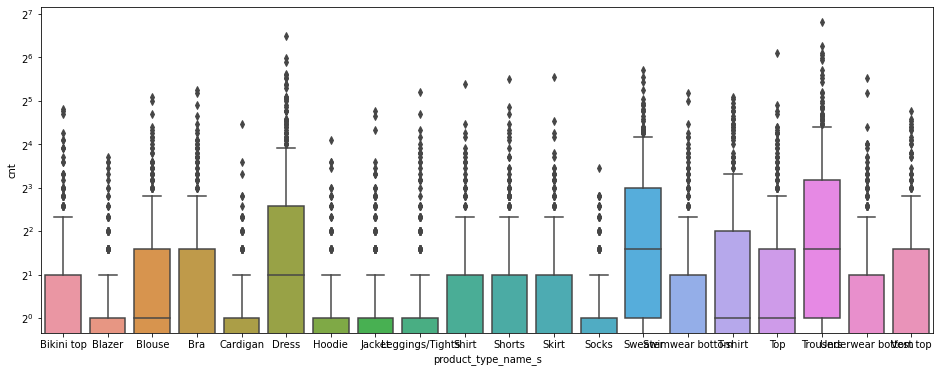

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
top_types = list(cohort_data['product_type_name'].value_counts()[:20].index)
w = cohort_data.groupby(['cid', 'product_type_name']).agg(cnt=('article_id', 'count')).reset_index()
w['product_type_name_s'] = w['product_type_name'].astype('str')
w['log2'] = w['cnt'].apply(np.log1p)

sns.boxplot(data=w[w['product_type_name'].isin(top_types)], x='product_type_name_s', y='cnt')
plt.yscale('log', base=2)

In [20]:
lst = list(w.groupby('product_type_name')['cnt'].describe().index)

C:\Users\sstamenov\Anaconda3\envs\kagglehm\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


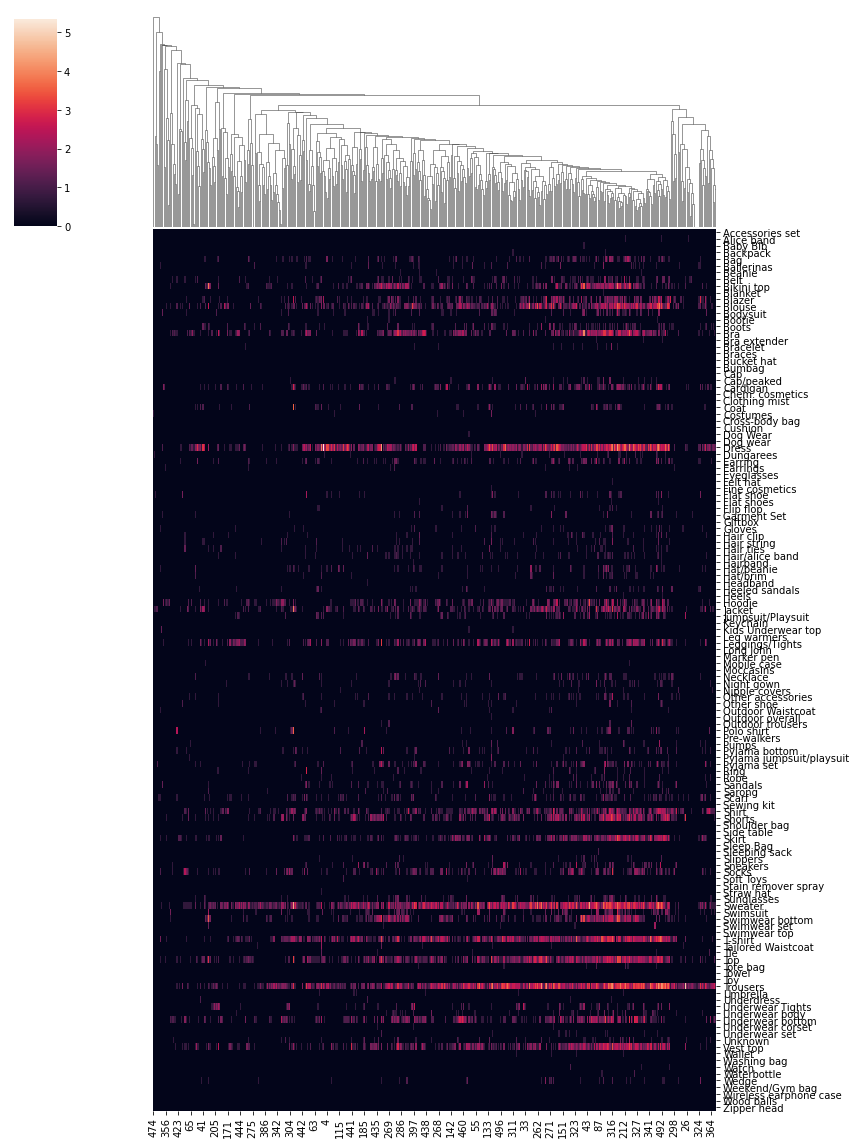

In [25]:
sns.clustermap(w.pivot(index='cid', columns='product_type_name', values='log2').values.T,
               row_cluster=False, figsize=(12,  16), metric='cosine', yticklabels=lst)

In [20]:
import umap

customers_pivot = w.pivot(index='cid', columns='product_type_name', values='log2')
reducer = umap.UMAP(metric='cosine', n_neighbors=8)
embedding = reducer.fit_transform(customers_pivot)
_ = w.groupby('cid')['cnt'].sum().reset_index()
_[['x', 'y']] = embedding

<AxesSubplot:xlabel='x', ylabel='y'>

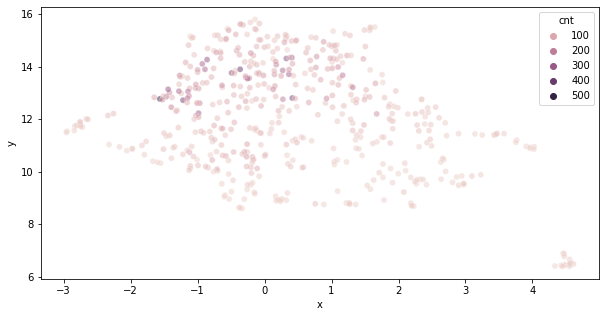

In [29]:
sns.scatterplot(data=_, x='x', y='y', alpha=.5, hue='cnt')

product_type_name is too broad category and it's hard to detect any customer behavior out of it, we need to go deeper

In [87]:
X = cohort_data.pivot_table(index='cid', columns='prod_name', values='article_id', aggfunc='count')
X = X.fillna(0).apply(np.log1p)
X.head()

reducer = umap.UMAP(metric='cosine', n_neighbors=4)
embedding = reducer.fit_transform(X)
_ = pd.DataFrame()
# _ = w.groupby('cid')['cnt'].sum().reset_index()
_[['x', 'y']] = embedding

prod_name                                           & Denim Boyfriend LW denim  \
cid                                                                              
0097b5a50eddfe1c310c9285ac3e47723ac45ab16c419b4...                         NaN   
00a619c0495f3feeff7cd101cdfaff0f266a3947672524b...                         NaN   
00ea7e241cb9879e0c1b887b133f78ec0566bef3a72443e...                         NaN   
00ea95b46de2a158c3853dc088c5a78319f895e6bd7f2e1...                         NaN   
023660ce786d75d70a40c9d4844862987ffd88c0b2613fd...                         NaN   

prod_name                                           &DENIM Boyfriend LW  \
cid                                                                       
0097b5a50eddfe1c310c9285ac3e47723ac45ab16c419b4...                  NaN   
00a619c0495f3feeff7cd101cdfaff0f266a3947672524b...                  NaN   
00ea7e241cb9879e0c1b887b133f78ec0566bef3a72443e...                  NaN   
00ea95b46de2a158c3853dc088c5a78319f895e6bd7f2e1...                  NaN   
023660ce786d75d70a40c9d4844862987ffd88c0b2613fd...                  NaN   

prod_name                                           &DENIM Embrace denim shorts  \
cid                                                                               
0097b5a50eddfe1c310c9285ac3e47723ac45ab16c419b4...                          NaN   
00a619c0495f3feeff7cd101cdfaff0f266a3947672524b...                          NaN   
00ea7e241cb9879e0c1b887b133f78ec0566bef3a72443e...                          NaN   
00ea95b46de2a158c3853dc088c5a78319f895e6bd7f2e1...                          NaN   
023660ce786d75d70a40c9d4844862987ffd88c0b2613fd...                          NaN   

prod_name                                           &DENIM Girlfriend RW  \
cid                                                                        
0097b5a50eddfe1c310c9285ac3e47723ac45ab16c419b4...                   NaN   
00a619c0495f3feeff7cd101cdfaff0f266a3947672524b...                   NaN   
00ea7e241cb9879e0c1b887b133f78ec0566bef3a72443e...                   NaN   
00ea95b46de2a158c3853dc088c5a78319f895e6bd7f2e1...                   NaN   
023660ce786d75d70a40c9d4844862987ffd88c0b2613fd...                   NaN   

prod_name                                           &DENIM Jeggings HW  \
cid                                                                      
0097b5a50eddfe1c310c9285ac3e47723ac45ab16c419b4...                 NaN   
00a619c0495f3feeff7cd101cdfaff0f266a3947672524b...                 NaN   
00ea7e241cb9879e0c1b887b133f78ec0566bef3a72443e...                 NaN   
00ea95b46de2a158c3853dc088c5a78319f895e6bd7f2e1...                 NaN   
023660ce786d75d70a40c9d4844862987ffd88c0b2613fd...                 NaN   

prod_name                                           &DENIM Kickflare deco  \
cid                                                                         
0097b5a50eddfe1c310c9285ac3e47723ac45ab16c419b4...                    NaN   
00a619c0495f3feeff7cd101cdfaff0f266a3947672524b...                    NaN   
00ea7e241cb9879e0c1b887b133f78ec0566bef3a72443e...                    NaN   
00ea95b46de2a158c3853dc088c5a78319f895e6bd7f2e1...                    NaN   
023660ce786d75d70a40c9d4844862987ffd88c0b2613fd...                    NaN   

prod_name                                           &DENIM Lou shirtdress  \
cid                                                                         
0097b5a50eddfe1c310c9285ac3e47723ac45ab16c419b4...                    NaN   
00a619c0495f3feeff7cd101cdfaff0f266a3947672524b...                    NaN   
00ea7e241cb9879e0c1b887b133f78ec0566bef3a72443e...                    NaN   
00ea95b46de2a158c3853dc088c5a78319f895e6bd7f2e1...                    NaN   
023660ce786d75d70a40c9d4844862987ffd88c0b2613fd...                    NaN   

prod_name                                           &DENIM Shaping HW ancle patche  \
cid                                                                                  
0097b5a50eddf

<AxesSubplot:xlabel='x', ylabel='y'>

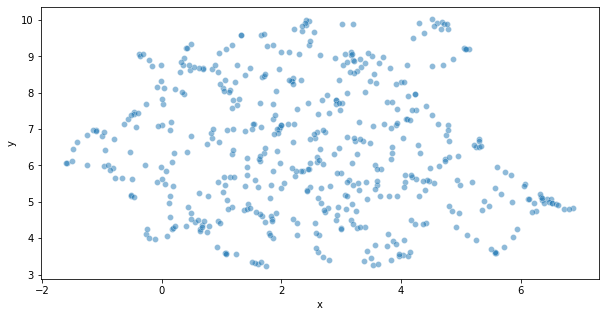

In [97]:
sns.scatterplot(data=_, x='x', y='y', alpha=.5)

# Global stats

<AxesSubplot:>

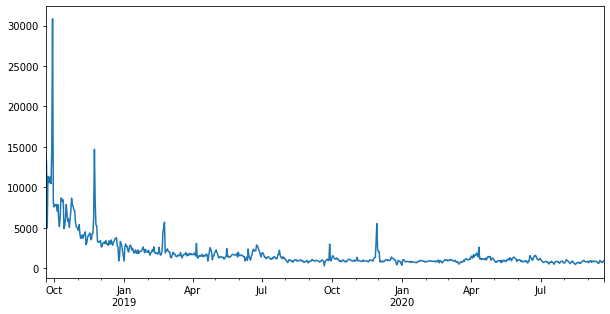

In [13]:
signups['signup_date'].value_counts().sort_index().plot()

<AxesSubplot:>

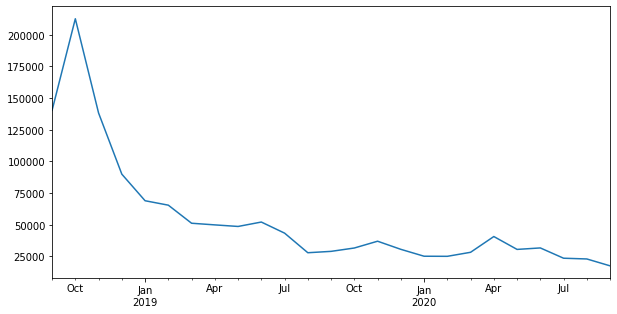

In [14]:
signups['signup_date'].dt.to_period('M').value_counts().sort_index().plot()

In [273]:
stats['prods'].describe(np.arange(0, 1, .1))

count   1024.000
mean      44.984
std       51.944
min        1.000
0%         1.000
10%        4.000
20%        8.000
30%       14.000
40%       21.000
50%       28.000
60%       38.000
70%       54.000
80%       72.000
90%      102.000
max      519.000
Name: prods, dtype: float64

<AxesSubplot:xlabel='colors', ylabel='Count'>

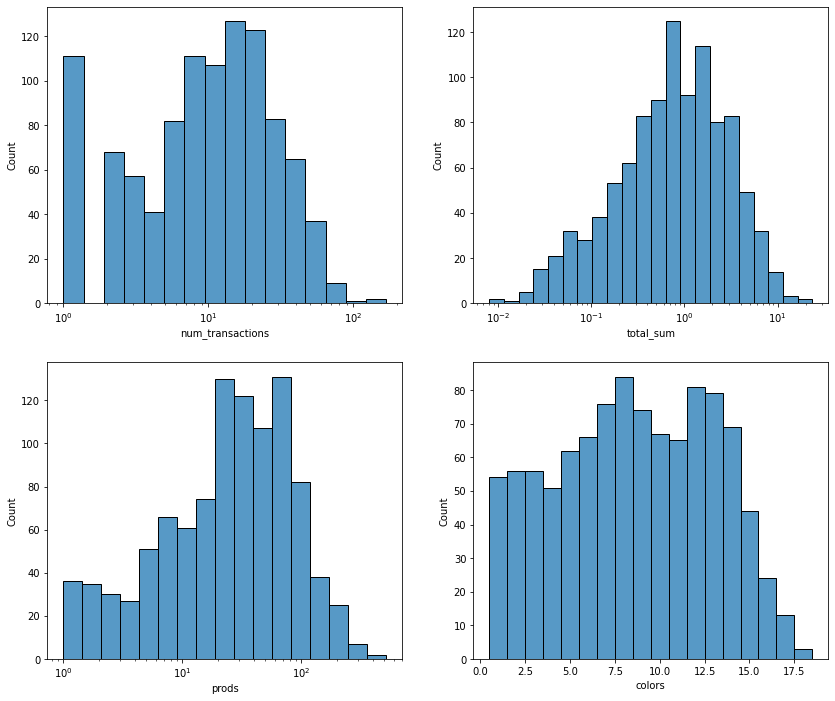

In [274]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
sns.histplot(data=stats, x='num_transactions', log_scale=(True, None), ax=ax[0, 0])
sns.histplot(data=stats, x='total_sum', log_scale=(True, None), ax=ax[0, 1])
sns.histplot(data=stats, x='prods', log_scale=(True, None), ax=ax[1, 0])
sns.histplot(data=stats, x='colors', discrete=True, ax=ax[1, 1])

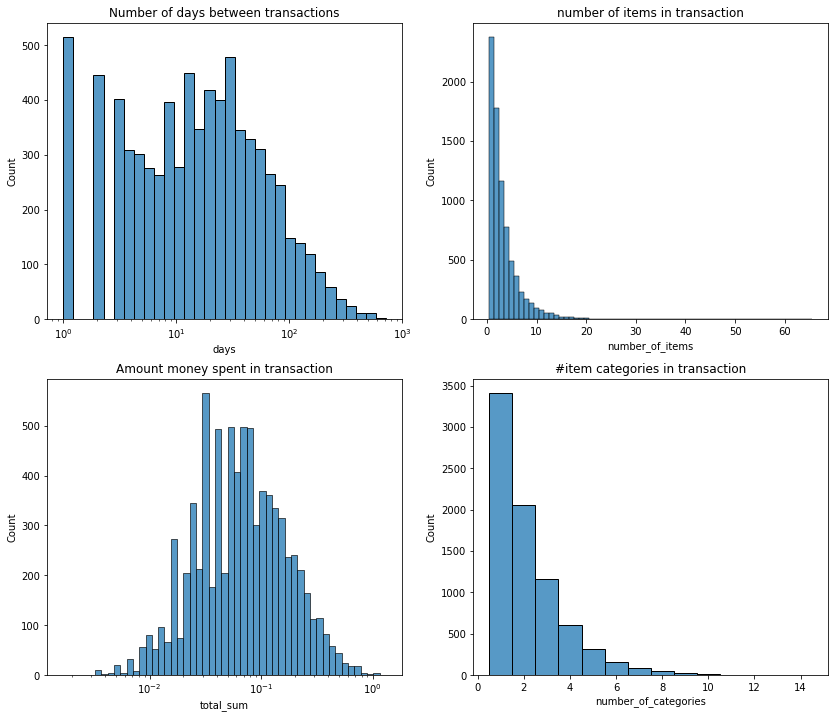

In [219]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
sns.histplot(cohort_transactions[cohort_transactions['next'].notna()], x='days', log_scale=(True, None), ax=ax[0, 0])
ax[0, 0].set(title='Number of days between transactions')

sns.histplot(data=cohort_transactions, x='number_of_items', discrete=True, ax=ax[0, 1])
ax[0, 1].set(title='number of items in transaction')

sns.histplot(data=cohort_transactions, x='total_sum', log_scale=(True, None), ax=ax[1, 0])
ax[1, 0].set(title='Amount money spent in transaction')

sns.histplot(data=cohort_transactions, x='number_of_categories', ax=ax[1, 1], discrete=True)
ax[1, 1].set(title='#item categories in transaction');

In [35]:
sales = t_ext.groupby('article_id').agg(total=('customer_id', 'count')).sort_values('total', ascending=False).reset_index()
sales = sales.merge(items[['article_id', 'product_type_name', 'prod_name']], on='article_id')
sales[:30]

article_id  total product_type_name                    prod_name
0   0706016001  50287          Trousers     Jade HW Skinny Denim TRS
1   0706016002  35043          Trousers     Jade HW Skinny Denim TRS
2   0372860001  31718             Socks           7p Basic Shaftless
3   0610776002  30199           T-shirt                    Tilly (1)
4   0759871002  26329          Vest top                   Tilda tank
5   0464297007  25025  Underwear bottom     Greta Thong Mynta Low 3p
6   0372860002  24458             Socks           7p Basic Shaftless
7   0610776001  22451           T-shirt                    Tilly (1)
8   0399223001  22236          Trousers      Curvy Jeggings HW Ankle
9   0706016003  21241          Trousers     Jade HW Skinny Denim TRS
10  0720125001  21063   Leggings/Tights            SUPREME RW tights
11  0156231001  21013  Underwear Tights                Box 4p Tights
12  0562245046  20719          Trousers               Luna skinny RW
13  0562245001  20464          Trousers               Luna skinny RW
14  0351484002  20415   Swimwear bottom            Lazer Razer Brief
15  0399256001  20242          Trousers    Skinny Ankle R.W Brooklyn
16  0673396002  19834              Belt                Ringo hipbelt
17  0568601006  19379            Blazer              Mariette Blazer
18  0448509014  19216          Trousers    Perrie Slim Mom Denim TRS
19  0673677002  19143           Sweater              Henry polo. (1)
20  0751471001  18263          Trousers          Pluto RW slacks (1)
21  0608776002  17886             Socks             Scallop 5p Socks
22  0160442007  17866             Socks             3p Sneaker Socks
23  0688537004  17754   Swimwear bottom  Simple as that Cheeky Tanga
24  0573716012  16690          Trousers              Kanta slacks RW
25  0158340001  16533   Leggings/Tights   Highwaist 30 den 1p Tights
26  0590928001  15906        Bikini top            New Girl Push Top
27  0579541001  15612          Cardigan            Calista cardigan.
28  0706016015  15571          Trousers     Jade HW Skinny Denim TRS
29  0554450001  15245          Trousers    Julia RW Skinny Denim TRS

In [36]:
sales['total'].describe()

count   104547.000
mean       304.058
std        791.266
min          1.000
25%         14.000
50%         65.000
75%        286.000
max      50287.000
Name: total, dtype: float64

[(0.0, 10000.0)]

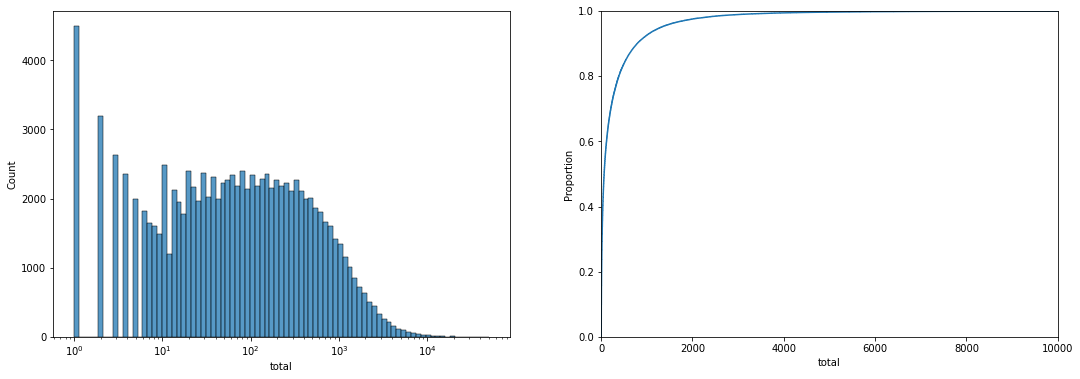

In [228]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(data=sales, x='total', log_scale=(True, None), ax=ax[0])

ax[1].set(xlim=(0, 10000));

In [37]:
def visualize_items(items):
    items = items[:64]
    fig, ax = plt.subplots(8, 8, figsize=(30, 30))

    for i, c in enumerate(items):
        path = f'../data/images/{c[:3]}/{c}.jpg'
        try:
            img = mpimg.imread(path)
            row, col = i // 8, i % 8
            ax[row, col].imshow(img)
        except:
            print(f'{path} not found')

# Top sales items

../data/images/061/0610776001.jpg not found
../data/images/061/0610776002.jpg not found


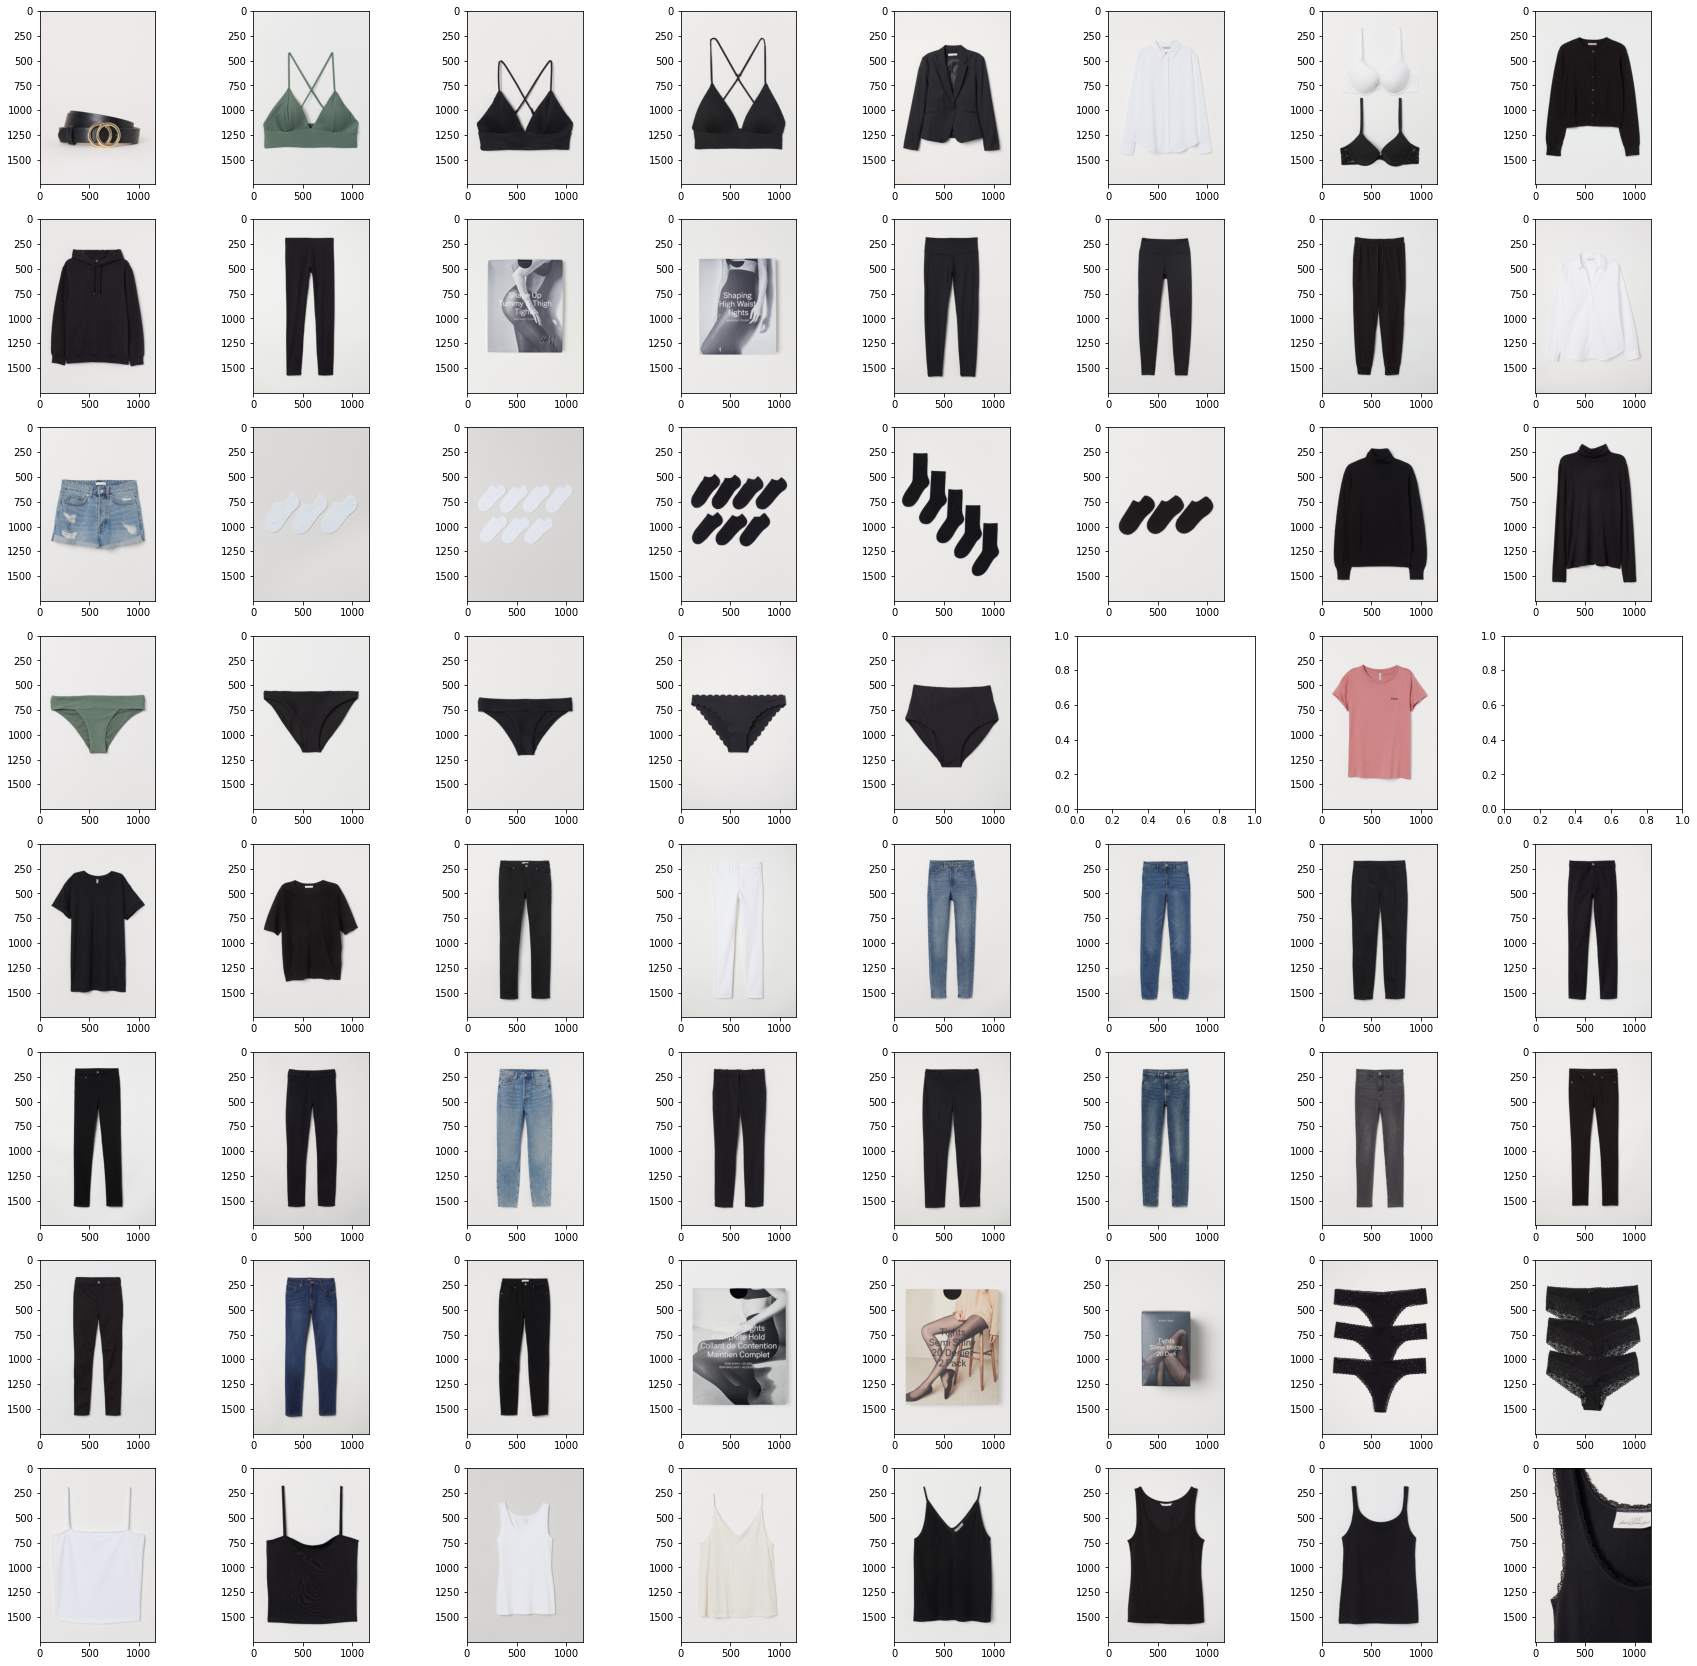

In [38]:
visualize_items(sales[:64].sort_values('product_type_name')['article_id'])

In [199]:
tsales = sales[sales['product_type_name'] == 'Trousers']
tsales['r'] = tsales['total'].rank(ascending=False)

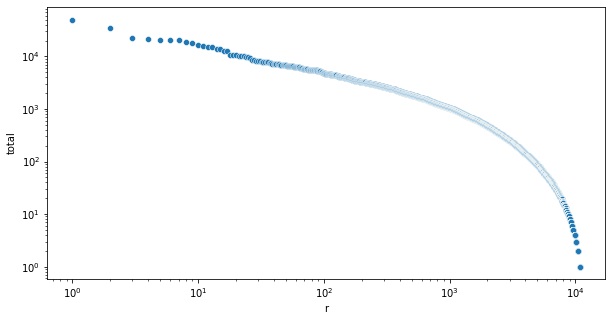

In [206]:
sns.scatterplot(data=tsales, x='r', y='total')
plt.yscale('log')
plt.xscale('log')

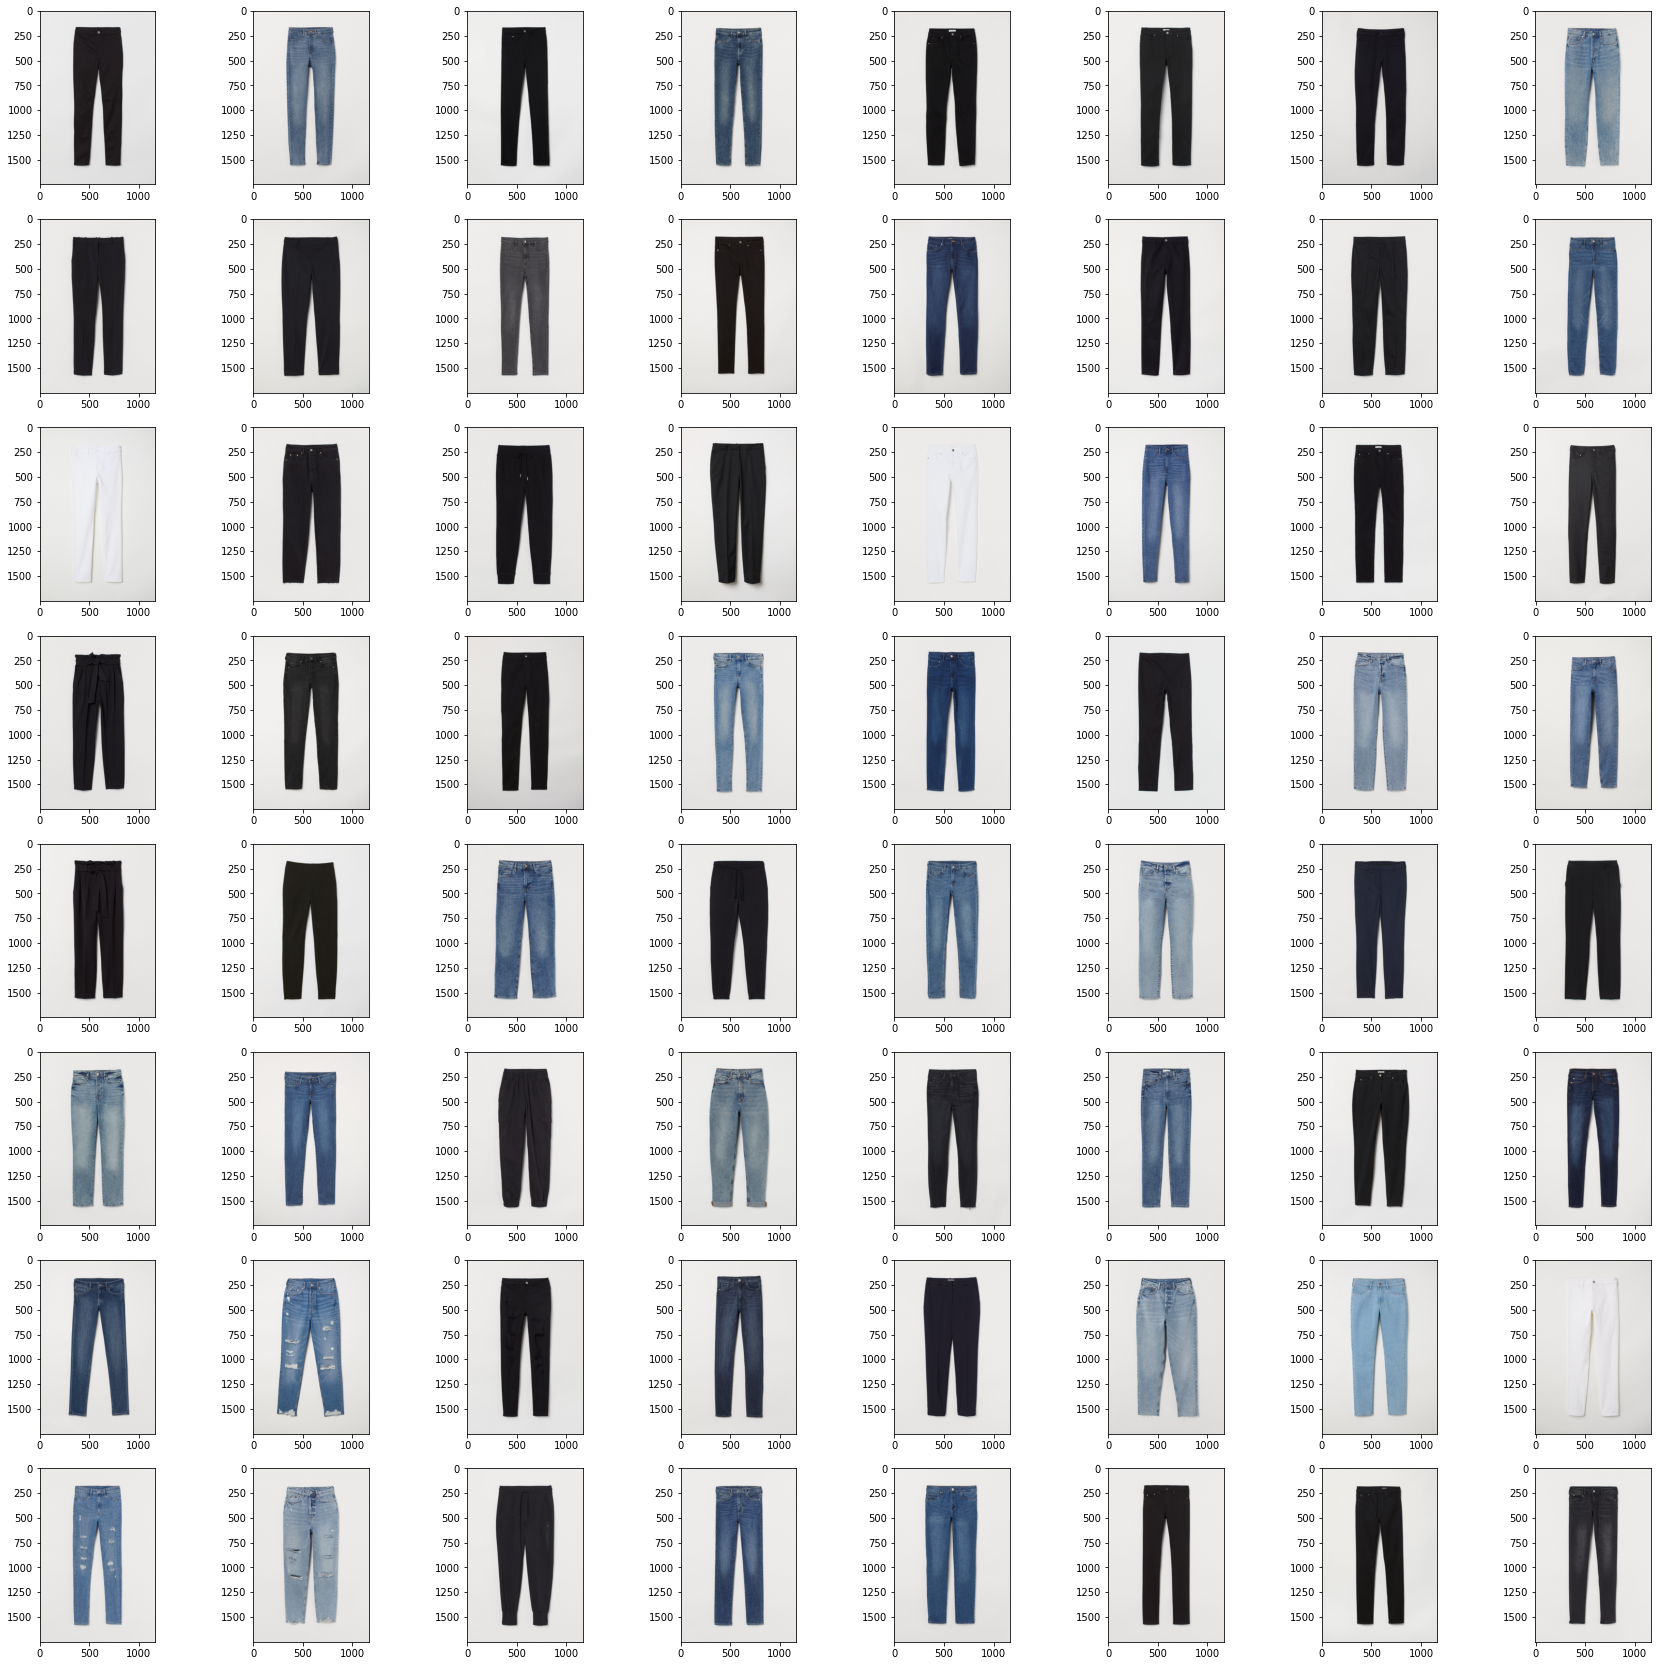

In [43]:
visualize_items(sales[sales['product_type_name'] == 'Trousers'].iloc[:64]['article_id'])

In [175]:
dep_item = t_ext.groupby(['product_type_name', 'article_id'], observed=True).agg(total_count=('customer_id', 'count')).reset_index()

In [233]:
sales.shape

(104547, 2)

In [238]:
sales[sales['total'] <= 10].shape, sales[sales['total'] <= 10]['total'].sum()

((22477, 2), 99347)

In [ ]:
# 20% of items <= 10 sold -> potential speedup

In [286]:
row = cohort.sample(n=1)
print(row)

cid = row['customer_id'].iloc[0]
_ = t_ext[t_ext['customer_id'] == cid].sort_values('product_type_name')['article_id'].unique()

t_num = t_ext[t_ext['customer_id'] == cid]['t_dat'].nunique()
cnt = t_ext[t_ext['customer_id'] == cid].shape[0]
print(f'number of transactions {t_num}; items {cnt};')

                                           customer_id signup_date
275  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...  2018-09-27
number of transactions 13; items 112;


In [287]:
t_ext[t_ext['customer_id'] == cid].sort_values(['t_dat', 'article_id'])

t_dat                                        customer_id  \
2830434  2018-09-27  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...   
2995569  2018-09-27  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...   
126027   2018-12-16  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...   
7453140  2018-12-16  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...   
1720998  2018-12-16  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...   
...             ...                                                ...   
30433035 2020-08-20  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...   
31084428 2020-08-20  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...   
31096805 2020-08-20  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...   
23011190 2020-09-16  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...   
31401817 2020-09-16  87bdafeaa7721a009482332f01a0fb85ae145728dd2ced...   

          article_id  price  sales_channel_id                     prod_name  \
2830434   0573085019  0.030                 1         Madison skinny HW (1)   
2995569   0675319004  0.051                 1            Bristol jersey blz   
126027    0448509017  0.042                 2     Perrie Slim Mom Denim TRS   
7453140   0473507001  0.034                 2               Lindsay shopper   
1720998   0532578017  0.010                 2                       Annette   
...              ...    ...               ...                           ...   
30433035  0907696002  0.017                 2               Jinny smock top   
31084428  0907702002  0.017                 2                      Tanga LS   
31096805  0907702003  0.017                 2                      Tanga LS   
23011190  0799365005  0.051                 2  Vintage Slim HW ankle consc.   
31401817  0894668003  0.025                 2    Brentwood HW Mom Twill TRS   

          product_group_name perceived_colour_master_name          index_name  \
2830434   Garment Lower body                         Blue          Ladieswear   
2995569   Garment Upper body                        Black          Ladieswear   
126027    Garment Lower body                        Black             Divided   
7453140          Accessories                        Black  Ladies Accessories   
1720998   Garment Upper body                         Pink          Ladieswear   
...                      ...                          ...                 ...   
30433035  Garment Upper body                        Black          Ladieswear   
31084428  Garment Upper body                        Black             Divided   
31096805  Garment Upper body                        White             Divided   
23011190  Garment Lower body                         Grey             Divided   
31401817  Garment Lower body                        Black             Divided   

         product_type_name  dow  season  
2830434           Trousers  Thu  Autumn  
2995569             Blazer  Thu  Autumn  
126027            Trousers  Sun  Winter  
7453140                Bag  Sun  Winter  
1720998            Sweater  Sun  Winter  
...                    ...  ...     ...  
30433035          Vest top  Thu  Summer  
31084428               Top  Thu  Summer  
31096805               Top  Thu  Summer  
23011190          Trousers  Wed  Autumn  
31401817          Trousers  Wed  Autumn  

[112 rows x 12 columns]

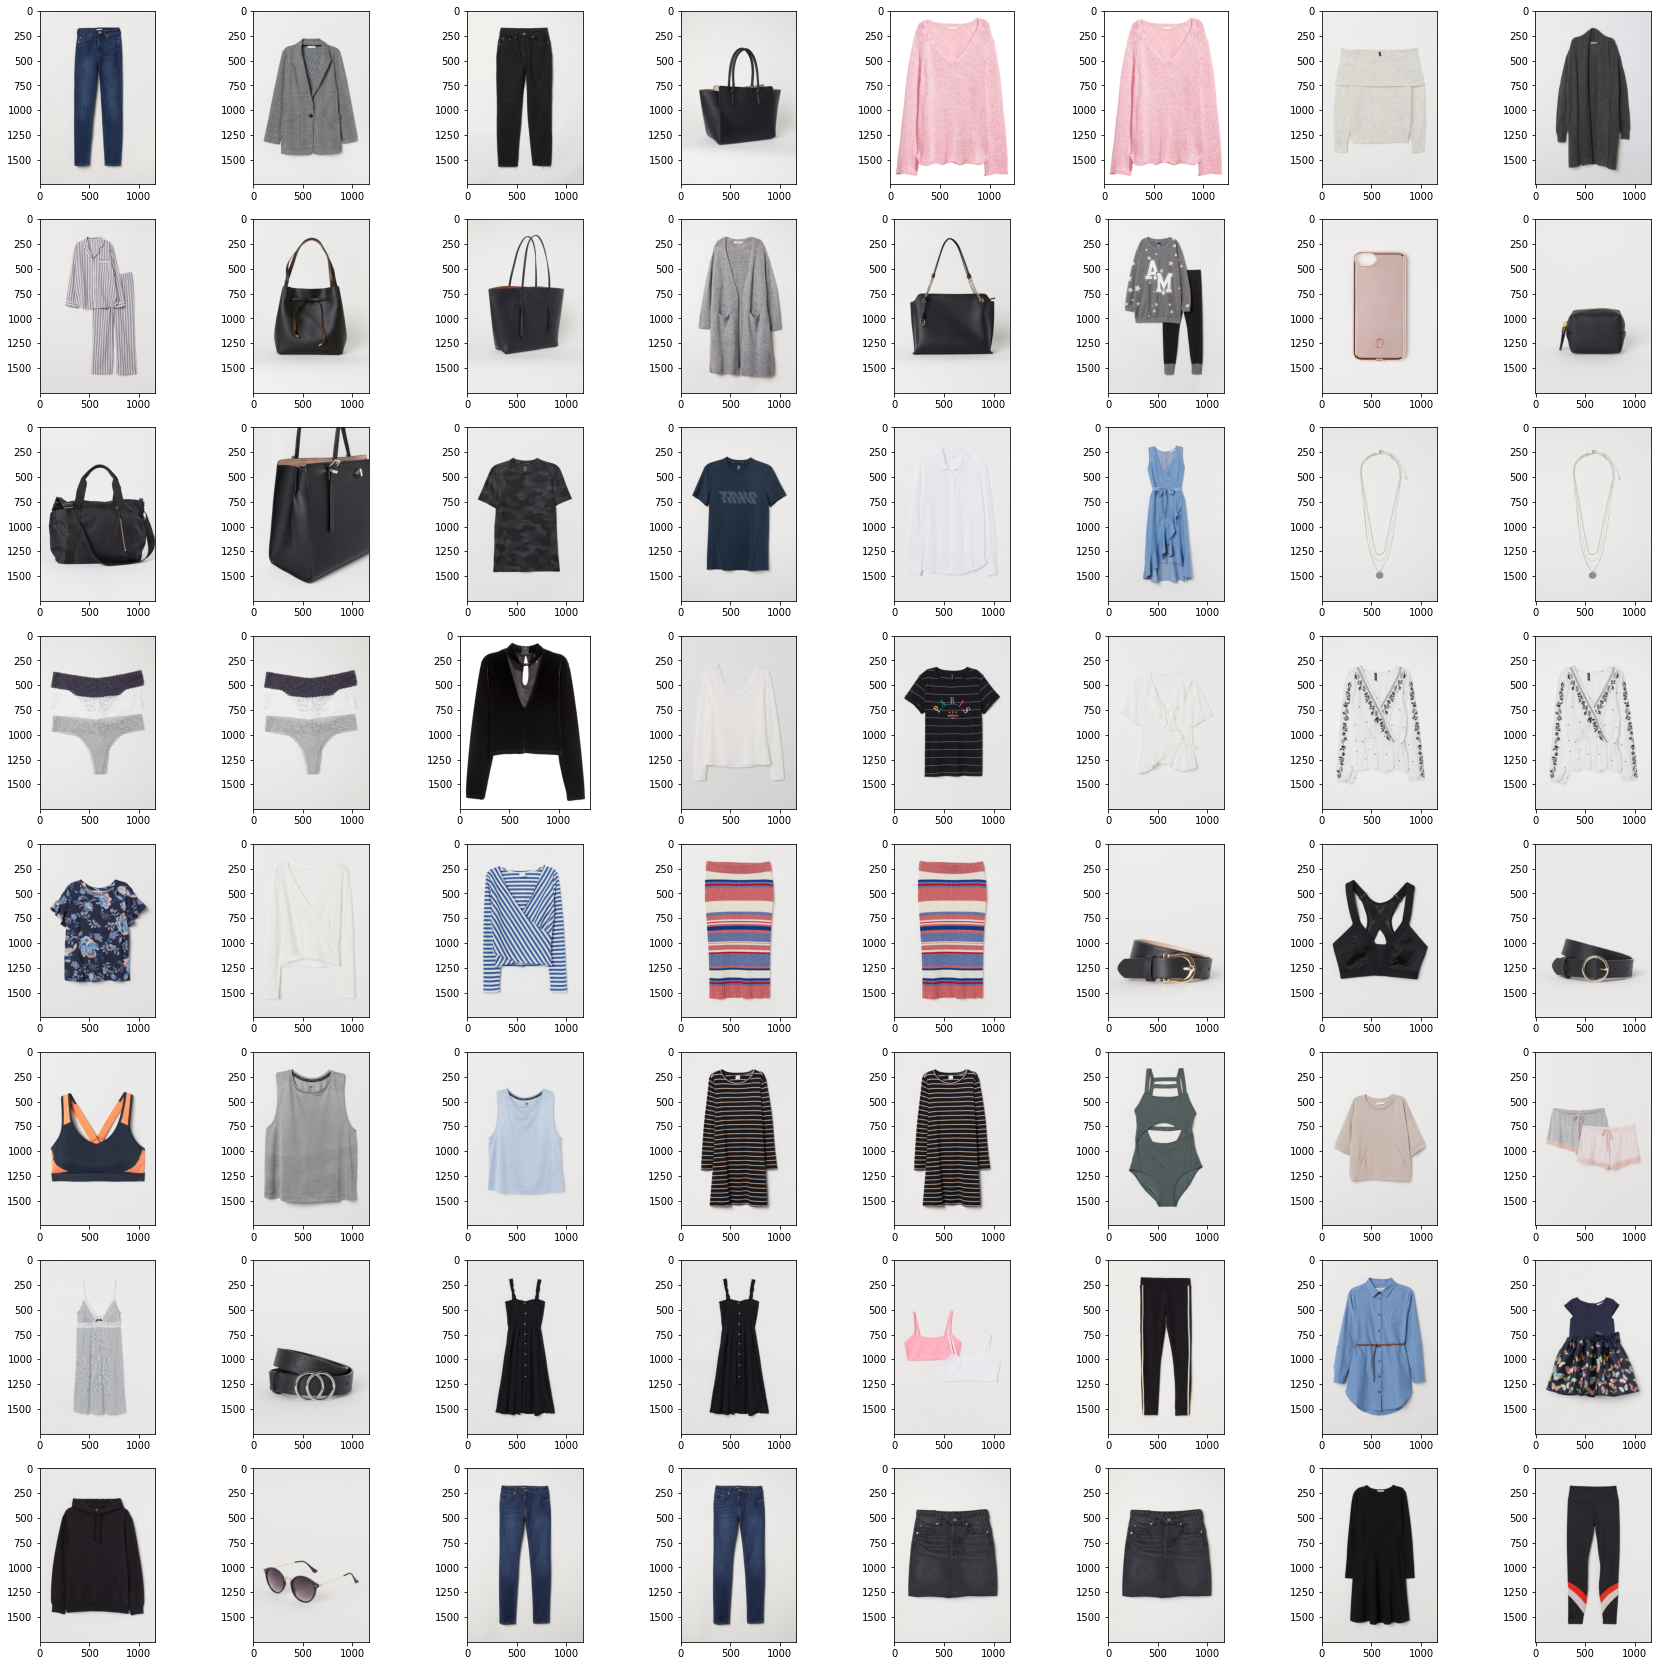

In [288]:
visualize_items(t_ext[t_ext['customer_id'] == cid].sort_values(['t_dat', 'article_id'])['article_id'])

In [310]:
t_ext['customer_id'].value_counts().describe()

count   1362281.000
mean         23.335
std          39.242
min           1.000
25%           3.000
50%           9.000
75%          27.000
max        1895.000
Name: customer_id, dtype: float64

<AxesSubplot:xlabel='customer_id', ylabel='Count'>

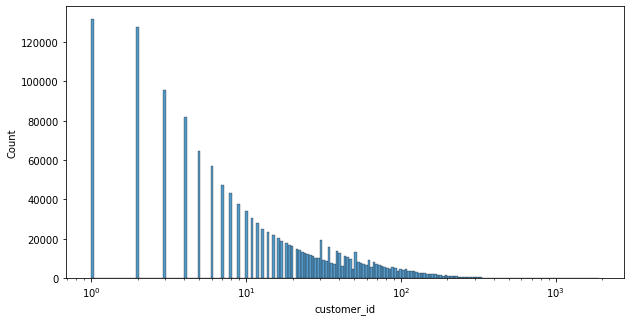

In [308]:
sns.histplot(t_ext['customer_id'].value_counts(), log_scale=(True, None))

# First transactions

In [232]:
cohort_data['t_id'] = cohort_data.groupby(['customer_id'], observed=True)['t_dat'].rank(method='dense')
cohort_data.sort_values(['customer_id', 't_dat'])
first_transactions = cohort_data[cohort_data['t_id'] == 1]

items 4;


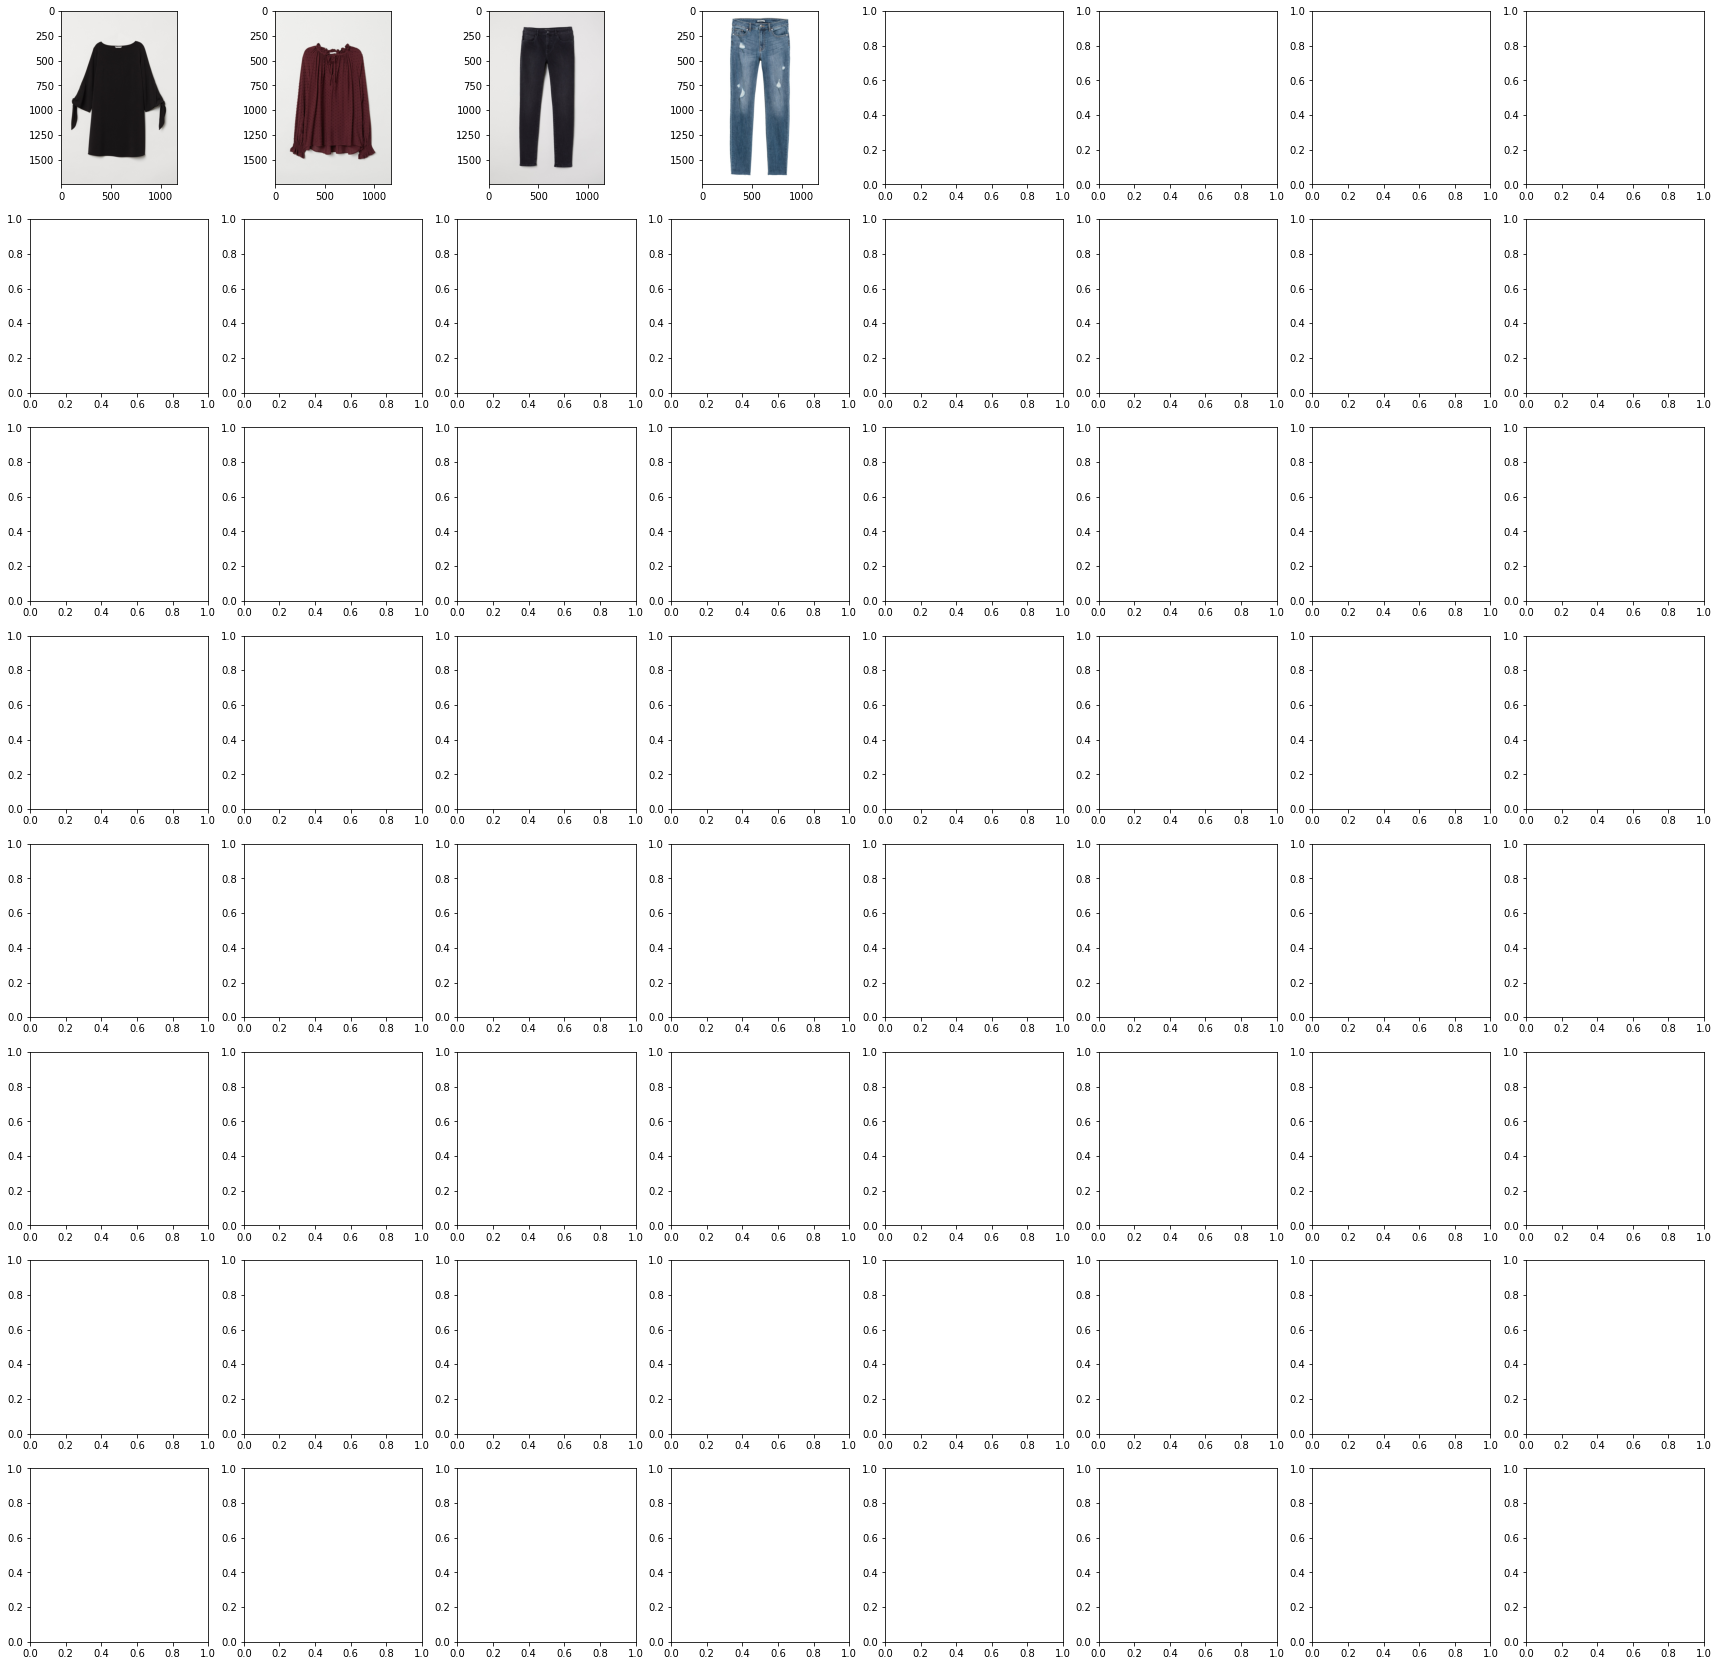

In [240]:
row = cohort.sample(n=1)

cid = row['customer_id'].iloc[0]
_ = first_transactions[first_transactions['customer_id'] == cid].sort_values('product_type_name')['article_id']

cnt = first_transactions[first_transactions['customer_id'] == cid].shape[0]
print(f'items {cnt};')

visualize_items(_)

for collab filtering we require at least X or 2 users to buy an item, let's check how many items are going to be discarded

In [168]:
item_users = t_ext.groupby('article_id').agg(users=('customer_id', 'nunique'))
item_users.head()

users
article_id       
0108775015   6885
0108775044   5284
0108775051    168
0110065001    945
0110065002    460

In [173]:
item_users['users'].describe()

count   104547.000
mean       261.188
std        637.907
min          1.000
25%         12.000
50%         58.000
75%        250.000
max      32251.000
Name: users, dtype: float64

<AxesSubplot:ylabel='Count'>

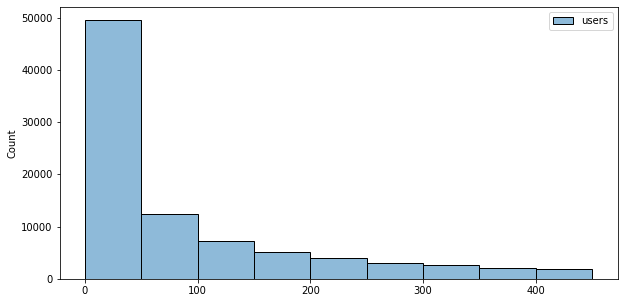

In [186]:
sns.histplot(item_users, bins=np.arange(0, 500, 50))

<AxesSubplot:xlabel='users'>

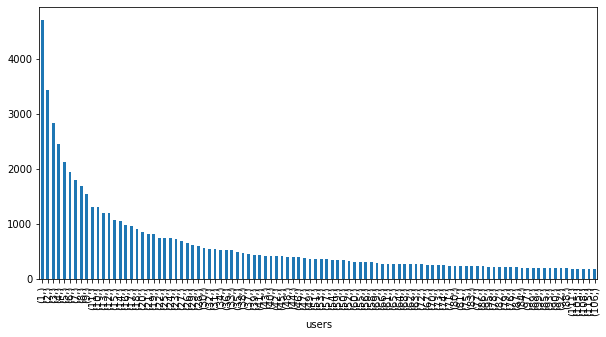

In [184]:
item_users.value_counts()[:100].plot.bar()

In [175]:
item_users.shape

(104547, 1)

In [242]:
# 5k items are not suited for collab filtering
item_users[item_users['users'] == 1].shape

(4704, 1)

# which items are bought multiple times by the same customer?

In [243]:
t_ext.head()

t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0663713001   
1 2018-09-20  3681748607f3287d2c3a65e00bb5fb153de30e9becf158...  0663713001   
2 2018-09-20  4ef5967ff17bf474bffebe5b16bd54878e1d4105f7b4ed...  0663713001   
3 2018-09-20  6b7b10d2d47516c82a6f97332478dab748070f09693f09...  0663713001   
4 2018-09-20  8ac137752bbe914aa4ae6ad007a9a0c5b67a1ab2b2d474...  0663713001   

   price  sales_channel_id                 prod_name product_group_name  \
0  0.051                 2  Atlanta Push Body Harlow          Underwear   
1  0.049                 2  Atlanta Push Body Harlow          Underwear   
2  0.051                 2  Atlanta Push Body Harlow          Underwear   
3  0.051                 1  Atlanta Push Body Harlow          Underwear   
4  0.051                 2  Atlanta Push Body Harlow          Underwear   

  perceived_colour_master_name        index_name product_type_name  dow  \
0                        Black  Lingeries/Tights    Underwear body  Thu   
1                        Black  Lingeries/Tights    Underwear body  Thu   
2                        Black  Lingeries/Tights    Underwear body  Thu   
3                        Black  Lingeries/Tights    Underwear body  Thu   
4                        Black  Lingeries/Tights    Underwear body  Thu   

   season  
0  Autumn  
1  Autumn  
2  Autumn  
3  Autumn  
4  Autumn

In [244]:
item_counts = t_ext.groupby(['customer_id', 'article_id'], observed=True).agg(total_count=('t_dat', 'count')).reset_index().sort_values('total_count', ascending=False)

In [270]:
item_stats = item_counts.groupby('article_id', observed=True)['total_count'].describe()

In [272]:
item_stats.sort_values('mean', ascending=False)

count   mean    std    min    25%    50%    75%    max
article_id                                                        
0740299001  1.000 15.000    NaN 15.000 15.000 15.000 15.000 15.000
0704760004  2.000  8.000  9.899  1.000  4.500  8.000 11.500 15.000
0331474016  3.000  8.000 12.124  1.000  1.000  1.000 11.500 22.000
0877607001  3.000  6.333  9.238  1.000  1.000  1.000  9.000 17.000
0701784017  4.000  5.750  8.221  1.000  1.000  2.000  6.750 18.000
...           ...    ...    ...    ...    ...    ...    ...    ...
0762061001  2.000  1.000  0.000  1.000  1.000  1.000  1.000  1.000
0762061002  2.000  1.000  0.000  1.000  1.000  1.000  1.000  1.000
0596400001  1.000  1.000    NaN  1.000  1.000  1.000  1.000  1.000
0528188004  1.000  1.000    NaN  1.000  1.000  1.000  1.000  1.000
0807908003  3.000  1.000  0.000  1.000  1.000  1.000  1.000  1.000

[104547 rows x 8 columns]

In [246]:
item_counts.describe()

total_count
count 27306439.000
mean         1.164
std          0.572
min          1.000
25%          1.000
50%          1.000
75%          1.000
max        570.000

In [265]:
top_repeats = item_counts.head(64)

In [266]:
top_repeats

customer_id  article_id  \
1370137   d00063b94dcb1342869d4994844a2742b5d62927f36843...  0678342001   
6760450   94665b46e194622ccdbcadc0170f13a2f8ede1ff6d057d...  0629420001   
2719289   61da44a2758206d5701771f4315637b40c8321b5111916...  0507909001   
23458631  ef38ec0f0cb29ee8bbb87efc82fd16f4b99127e3eeefe6...  0570002001   
391863    5cba04ed9a3759bc02a8a9e01efccc07ce76c35c1a70dc...  0688558002   
23052598  ebc0f83524828ee05e9dc70b50d21a261000d2015f6b20...  0685347001   
19168600  ce79a54991bb7c2c2d9427ae1e7f1d8c8b037f8d74b2fe...  0570004009   
21700198  d5902b0523749b377ab32f6de5e9a739cf690bb8dd0aa5...  0179123001   
5340084   0152964ef19824d631d28ee3327a010fbfc528cdaf5bf0...  0756322001   
20721379  8f5f1e993eff204ca7206cabe0fc6dfb75759994cacbf4...  0189634001   
8876629   c163adbcac6e42e600224be5e1682a5b840e1d430c443a...  0689365047   
19779048  a84515abd71b2102b4fb7e6ac3fd7ef67ce714310cac81...  0708705001   
18401617  a81e0b7657a090198d8138c95fae7db1218305b97bb8fd...  0618480001   
26618888  18d346ffea696df26aa1d53ee19afbf250a92288fc1282...  0719348003   
5834666   91f3ab5944411eb3f6f79e93ab430f3d4ff92e5a5d4475...  0728162001   
26433170  9c23e0fc07795d624a76cf77dfa565e788685424b4fa19...  0607642008   
2891140   bf996b5fba090a52b2cfe9324bdc313a3ac3b1417bf9a9...  0772005005   
21766277  f11ddea20db46fd5f005b6bb0ec4b083f6765d2b03e241...  0557247001   
27188369  1472c551f2c04873edddc853e214a033692b2b1d6ae2bb...  0852521001   
25347567  1c61a6d8aca42d746c76a07d0c57e74c67890dd12d9fc7...  0695545001   
25832636  8d70381b62a1d3e6d057a6d006ea52f65aded5c3657335...  0685813001   
1370111   d00063b94dcb1342869d4994844a2742b5d62927f36843...  0561445005   
26593456  006d4d3564072c27710509891093efa1324be6aaef0de3...  0727880001   
5834542   91f3ab5944411eb3f6f79e93ab430f3d4ff92e5a5d4475...  0189634001   
2625536   98c353d379796e9ac56c90ab2492b2070efcbfc6fa8ab0...  0507909001   
24734408  a77ced28f1ca69f3a154cee61b42bbf4933ed483f1d515...  0685816002   
27076651  8de98d98789e2d90eb7d8b3b631e0a7d895aba860124a2...  0828047002   
24115746  9f2b4a44d60839053860ef9035317120c992287b78c9fb...  0751471042   
24422965  10411ac70c80005a535783ede440e0de5df6a1d7ff25fd...  0711053003   
15232205  c7dbda0e6fd654592d3e25bba513467e9c4329edf3e6db...  0714176001   
8528118   c6e14fffa49db6ba1f4f95a985d4b5a1ca5e6b3611fed5...  0664074001   
15232202  c7dbda0e6fd654592d3e25bba513467e9c4329edf3e6db...  0702366001   
2720234   f29ceb51b850338601136bcc6c4b1373ceeae889827a74...  0507909001   
16320374  8d2c33a1b060ce16add06f3742447115e5aaea20e847c1...  0668537001   
13505772  716dbafa8ff9a79753e97bdbd1386bd9d8317153eb4d46...  0691695008   
2731232   4580cd313d03eb3ebf66a9da1137f50c84d92056c15926...  0507909001   
2719288   61da44a2758206d5701771f4315637b40c8321b5111916...  0501616007   
19168881  a83c53a12ae9e4a1d8a2a32f376cadd45600f22977a904...  0123173001   
2810085   0501552eaebc51b1199e9f900b5ba7bedf975624787d6b...  0568601006   
19152958  ac509cee4a8253e1797944e2f4478a002605f4d6187286...  0123173001   
13667817  d6ca1b7a7b125811ddd5bade1ec3ab33326194afe976c0...  0682550001   
26395183  0ec99d50abb096d32a02176225be88ab6cad11133f06ff...  0718278001   
27032878  0b2e727032e3c559b7baf3f600a036d16d73f5d3c0e1c2...  0781833004   
3006830   29d7cbdabbb1e66eae45fd81aed70ceb3d1836df06f2f2...  0695632001   
26492790  dfe3b3e5ead71d20e6a742cfd4ae388ad5cf3836595577...  0681180003   
20192053  5a74b11a6dd495480f4fbc7ce78c8b9d069078ba781590...  0189616008   
22526223  04dab48e5805e9c05272604ac78eb5eb941850ce307a7d...  0695544001   
27040635  2f79d91eb005b934dffad986d217b8ce6e4bde1bdb0d0c...  0753214014   
20264250  a6f23def84decb02af89ae94c44c1c61a2bf3462ca90df...  0669091001   
26512281  b2be5f6fcc8176740dd083d40a39c535be48f5d630d46a...  0715255013   
25740571  e8485f92b12113c2c8e17649165e52fc8818b2ac8e17dc...  0577513003   
11101894  26c1818ce5c26856f4456f1da67977fa90512db5c1aee9...  0695632001   
22526222  04dab48e5805e9c05272604ac78eb5eb941850ce307a7d...  0568597006  

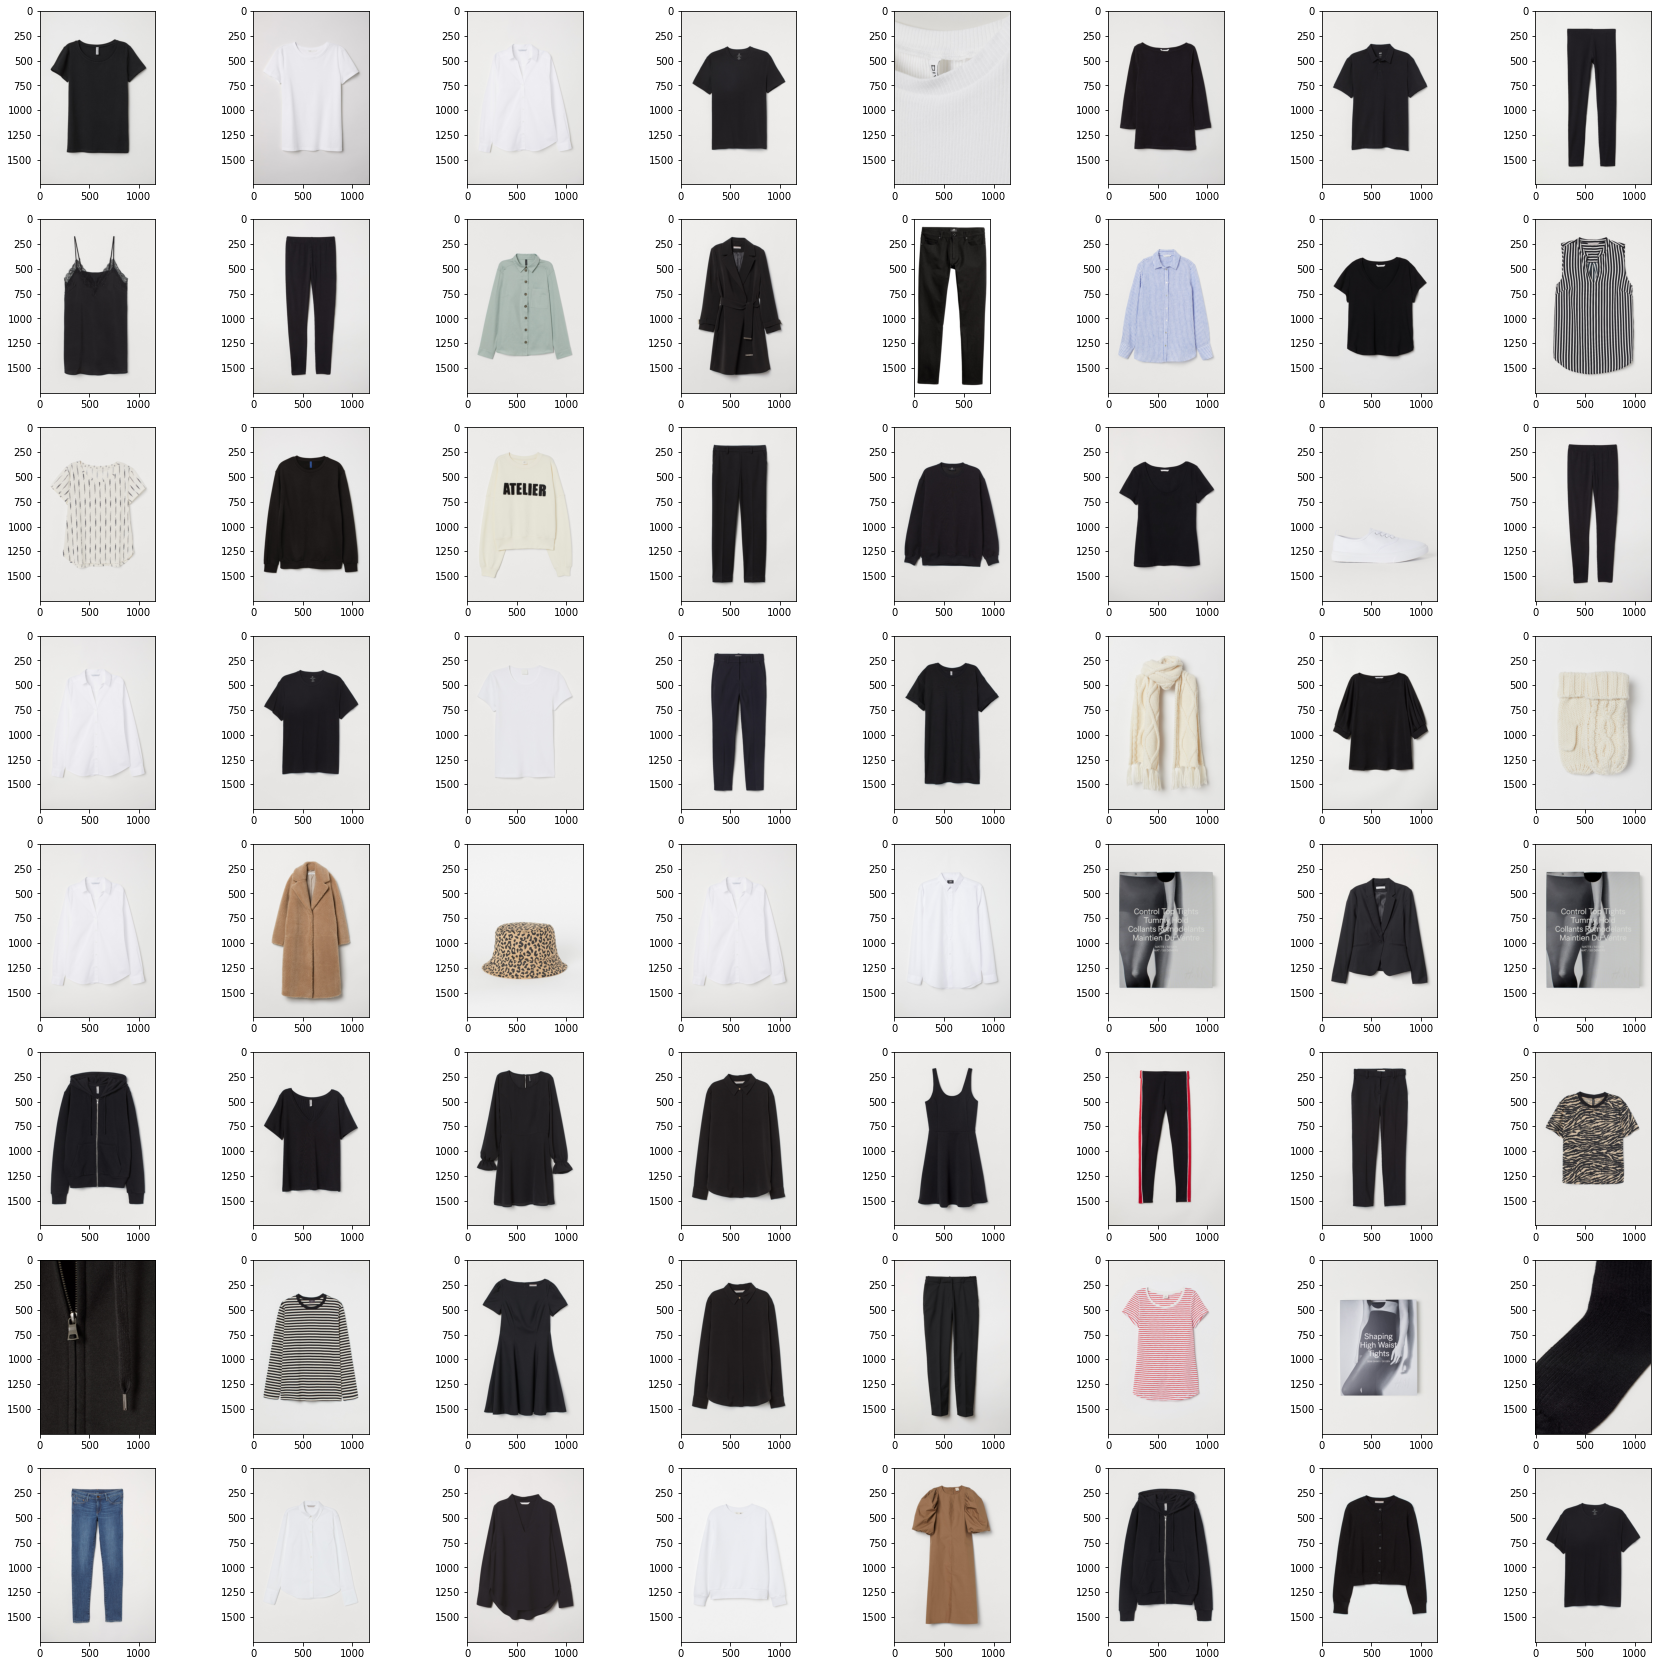

In [255]:
visualize_items(top_repeats['article_id'])

50 items per customer seems rather too much to be true, most probably these are some odd batch buyes

In [268]:
item_counts[512:600]

customer_id  article_id  \
15686310  709f7599e02bf10918c2232aa36769d3264db7603dff11...  0763196002   
1992354   20c550ce8164cefecf43e8f7620f367ddba6d5467e3a6d...  0572797001   
16723452  c0415cd0a2d1844552d6f761f0ed1464f3f7880b23afad...  0561445005   
26584598  6a322afb776cde27920c24145d703d7e1f2715396e7a73...  0758397003   
21891573  cc12787dee14dac0091aec0505632a045ef261cdc12c0e...  0764624001   
15148363  a87ce322ea91a8d1926e5d078e4e903a86837028a01010...  0717464001   
23998607  a55b373e2df5adc2a955881588196ca90ce9522e3ab993...  0598755002   
23892991  66a0f7dcc8232b204c4e5398b3f0b769260d6210f39f1d...  0682050002   
25149816  322d4e5924c91b805defb1afa30772a0a816ff6aa2c6f9...  0573282010   
26903466  afcd22fe154f9c3bd68f07d69bcf68c7c26f8b1073845a...  0685816023   
22827960  c952bb0d3a4f2d55c58ee264ee20fdac80276ba7819de9...  0366686026   
9622720   784ccd3094123ea8e26743bfbef116f0964f7b3c75bcfd...  0158340001   
16989989  191eba405ddc27a3862089244be4248fe03d4a8ecfb748...  0717490003   
25858986  07b1a6ab824654874a4be6d85491250c82e5a98b0a8e1f...  0816587012   
12944885  50b1dda66692476b38a73d6d425d3a58edfcd835dee171...  0228257001   
21768173  63d82e512a3e0587d929eadc98ae0c37ee9eeb9faab6d0...  0677930015   
18402638  e88db70e4a7142cab9a6b1158a1e52ce790ee9d2e86363...  0762856007   
19982977  56f4085cf351b9124e2be3c5798e1cb7f5e4451096a2b3...  0569984001   
25625438  118767f021f9e34551e0af5e8b9a815382ef1c71f82849...  0688873009   
7889976   b3273672028476e603e6b8ea82b83b2137b3c42c7a6813...  0677930023   
20519925  b00e7a73ee2575cd81f3d156c8f25aa082fb5ae3da8607...  0111586001   
13497292  396d64b69b86e33a58b255507fa7cdab41f5f54ba2c6de...  0156231001   
7050858   a6c1c70b77da6e6a7979b8d3b16704081c4748420ab7db...  0685813042   
7050857   a6c1c70b77da6e6a7979b8d3b16704081c4748420ab7db...  0685813037   
20949390  2683c3d18fa3e81ac2e6a183617ca3e90522e1357b5654...  0772005004   
9758275   cbd6688597632dca2adc37173727681ab3099d18edff52...  0777756002   
19540699  fa3f7e9e326ec86c8f918b17cebb9a73577455efff1766...  0712838005   
2752376   89ed50c69f698e546c4327764dadfa302f9be57d009eea...  0507909001   
10462688  6e91d482c348bc118d8d00df01b73f72471d194987616f...  0694198002   
24969860  b66a9b0edc8dfbd2a6a0b4a06629957ca486ed60e61d96...  0573282010   
3828498   62ec7f58daffa7038f1c886097249023eb7d7b8e02e704...  0156231001   
24006975  62fd7d41b587c72a95c31eca5046019ce4e802853397ff...  0642882001   
1071031   65d3fe53c1daab078c0f6b538cc85ee24f08aca9755291...  0608458001   
6041709   e2647bc127e33c064cebad77fe359df228fe34b841341d...  0820960001   
21669411  f3ed3a45f6909c87e5a436d93ac6b34969381d698dbd68...  0700938001   
8528171   c6e14fffa49db6ba1f4f95a985d4b5a1ca5e6b3611fed5...  0918443002   
2077370   67fd424f8865fdba462f783f8038fe9db6f217bb99f3d3...  0610776002   
13667808  d6ca1b7a7b125811ddd5bade1ec3ab33326194afe976c0...  0557246001   
10860360  eae4ef48cf75834a5ebf1936967ea86a9cf1e1098ce8b8...  0160442007   
19582077  b05ebee4ae79cf2a949fac159d145728baabae5276fe90...  0825771005   
13025674  16c913a4769b1c4e34a696ba53dfe47f5697da8a45457f...  0355569001   
16623785  6c71921dac19f7f09860e8d032a7beb2941d877a77cc76...  0800691008   
1981181   4add4e64898ea4148da904f8cc00f1482e09e57c020be2...  0801554002   
7758310   80452114d406d602f75d73fc84bf745688d322e901623a...  0399087028   
23601789  6db23132b001ce1603e5d6e5a06da1caed49ebc41092e7...  0636587001   
15313033  fc477c3361ab53d7b5d771816acb6c2a718dc200c681ad...  0569974001   
7258691   08aa7a6cfdc5c99f698e80eba3b12921f4ec5c7bc057f3...  0558524013   
26579573  229721e6a27b6e35c6f29b014c62c9b4ab89385ec06346...  0733935001   
6078632   b1c653725761b27d97b08ab5460578e1d5385695f745b1...  0708138021   
7485406   8f941fec5107ae66fcf8d0422c770e03491ab1d444cab9...  0537116001   
22970811  2ecbe45423212259a899900ae48267ce87cead96ebd2a7...  0717490003   
10758937  2e66e7ab67d6d29f30c39c2049bcbb8103b6b2a2a34705...  0624257001   
25441224  e05e652d4bd3340999a3acfcf0a4c597f42ebd316de28f...  0561445007  

In [ ]:
visualize_items(item_counts.reset_index().sort_values('total_count', ascending=False).iloc[64])

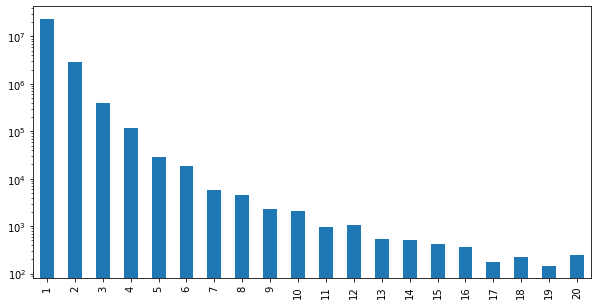

In [261]:
item_counts['total_count'].value_counts().sort_index()[:20].plot.bar()
plt.yscale('log')

# NN exploration

In [5]:
# build an index article_id: set(user_id)
inv_idx = t_ext.groupby('article_id').agg(customers=('customer_id', set))

In [6]:
cust_items = t_ext.groupby('customer_id').agg(items=('article_id', set))

In [250]:
cust_items['set_size'] = cust_items['customers'].str.len()

In [10]:
inv_idx['set_size'] = inv_idx['customers'].str.len()

In [11]:
inv_idx.head()

customers  set_size
article_id                                                             
0108775015  {d840cbc99f3056ec2b32c741b2d29fcaa204a26979ee8...      6885
0108775044  {b47b082586fae0fab7c2e82854d55e5845009eab8753d...      5284
0108775051  {5632fb2043bb07988d6959157857d26e28b2ae39afca1...       168
0110065001  {6178375a70157088f7b8bddfd76feff0f9079159701ab...       945
0110065002  {4e936763ff8a6cd5de4b6e4cfa53e667e435d60aebf72...       460

In [264]:
cust_items['set_size'].describe(np.arange(0, 1, .05))

count   1362281.000
mean         20.045
std          31.980
min           1.000
0%            1.000
5%            1.000
10%           1.000
15%           2.000
20%           2.000
25%           3.000
30%           4.000
35%           5.000
40%           6.000
45%           7.000
50%           8.000
55%          10.000
60%          12.000
65%          15.000
70%          19.000
75%          24.000
80%          30.000
85%          38.000
90%          52.000
95%          77.000
max        1346.000
Name: set_size, dtype: float64

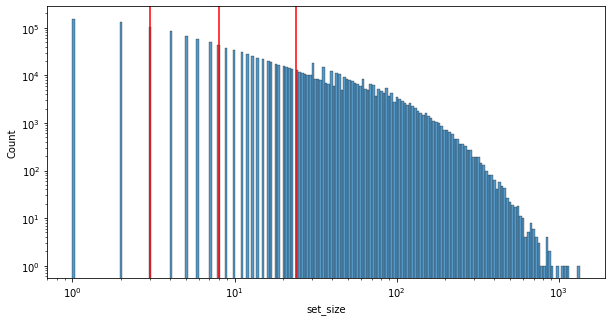

In [266]:
sns.histplot(data=cust_items, x='set_size', log_scale=(True, True))
for x in cust_items['set_size'].describe().loc[['25%', '50%', '75%']]:
    plt.axvline(x, c='red')

In [14]:
item_customer_lookup = inv_idx['customers'].to_dict()
cust_item_lookup = cust_items['customers'].to_dict()

In [16]:
item_customer_lookup['0108775015']

{'d840cbc99f3056ec2b32c741b2d29fcaa204a26979ee891dac558fc5ea5ee8a1',
 '2dfadf2390fb395cfb7b3afdc36a52f1b1a3a024273cfd37a7012361b4f0a4f5',
 '0c1782ceae48ee3928e3d5fdfa7e9eb1838a21a6549058ea3058e057daeae29d',
 '8a32d0beb4df2d975c2a5e50eabd2b0a846b944527a2b39e9fbfe28bb8bf9824',
 '5f0d8996c8ffd21107b1033e321bab8108a64093830877a52c468524c8ca02da',
 '4d1d7ed159db28e9836b27353ca607def16dca466c5a3c549134c9a86361e0d5',
 '3989cfee8dbd81074661fcbe961f8a9a5c9947b6d78b0a2c1f5cb93f8f5d0557',
 'a561a2d9e1c4cf660fd4d273df4be5215ffedc4654ab911e7207dfd4105ed674',
 '77dbbf9547952322557eb475b1db45a395662762e3f27f90686f2a9ae3065470',
 '65f5770705cf3e3ff301f043d2f85efff3e24ef98ffa4a093c8ec34c303e50bc',
 '32aaf98706380c0d419959796603d5fca23157e8288e8e0e9234a856efe8bd94',
 '9f2374e5f3c9a0a68defada974e677d9761b6d849d2574fb3f3ac234a2e9703b',
 '11e88b4b39fd3d548d56637b9c8e836c2473c6bd2e5999e44f29c6dc18adffb4',
 '88e45c5e258da53f862ff847d609f81d88aa00dedc5a55187f186246ad137e06',
 '67df9897460187f1df8b202aae173961

In [20]:
u = cust_item_lookup['d840cbc99f3056ec2b32c741b2d29fcaa204a26979ee891dac558fc5ea5ee8a1']

In [21]:
v = cust_item_lookup['2dfadf2390fb395cfb7b3afdc36a52f1b1a3a024273cfd37a7012361b4f0a4f5']

In [22]:
def cosince_simil(u, v):
    return len(u & v) / np.sqrt(len(u) * len(v))

In [ ]:
# u = <user-id>
# neighbourhood = set()
# foreach user-item get all customers and add them to the neighbourhood
# foreach user in neighbourhood, calculate distance

In [276]:
random_ids = np.random.choice(cohort['customer_id'], 250)
random_ids[:10]

array(['e8fda3a2abdbc494235178cb36339a175b5032c30e37a22699f36c5a2aec3065',
       'dd9b3ad310049cdecc6f5191c44df3005176a0ec887bb132ec4b1960853b71d3',
       '3fae276c767083e19619dfc286c4bc0bd9adea7deecceaa7459d024d9545046f',
       'dde1fa7726ae756557134c332acd4255be2d6db7a006a90fc9d95f0fa8f43ce9',
       '2b99de93edf4f2a162c69cf7a6fffbfd082731db3799cc9a6773d9eb8b51053b',
       'd7e04bd0bb011e21bc2dfb875b0381582ca9e68a3a36773215154578e1888f60',
       '5ad680ef67bf5625284c71ec41c814c43c46ae768b995492ac482a7114a862fe',
       'ba10af53badaf50657b439f465c0971b4bd4059ef4543eeac2e6058ce5ed8736',
       '5a9917ae0fd5085e1ad994f06b1de8763d25dc89dd080f24688e10cc737167b9',
       '1322812d2003d58e8228d05105a0cb95fdeb9dc365020ba27efd1daac0c39919'],
      dtype=object)

In [277]:
def calc_simil(random_cid, cust_item_lookup, item_customer_lookup):
    neighbours = set()
    for aid in cust_item_lookup[random_cid]:
        neighbours = neighbours | item_customer_lookup[aid]
    rv = cust_item_lookup[random_cid]
    similarities = []
    for nid in neighbours:
        if nid == random_cid:
            continue
        u = cust_item_lookup[nid]
        r = {
            'simil': cosince_simil(rv, u),
            'len_b': len(u),
            'len_common': len(rv & u),
            'len_a': len(rv),
            'b': nid,
            'a': random_cid
        }
        similarities.append(r)

    return similarities

In [278]:
result = []

for cid in random_ids:
    result += calc_simil(cid, cust_item_lookup, item_customer_lookup)

In [279]:
pdf = pd.DataFrame(result)

In [280]:
c = (
    pdf['len_b'] != pdf['len_common']
)

pdf[c]['len_common'].value_counts()

1     12177598
2      1853572
3       389985
4       107644
5        34746
6        12882
7         5203
8         2222
9         1137
10         521
11         264
12         134
13          64
14          50
15          22
16          20
17          11
18           9
19           7
20           4
22           2
21           2
26           2
23           1
42           1
28           1
29           1
Name: len_common, dtype: int64

In [281]:
pdf['krank'] = pdf.groupby('a')['simil'].rank(ascending=False, method='dense')

In [242]:
pdf[['a', 'len_a']].drop_duplicates()['len_a'].describe()

count   250.000
mean     20.160
std      32.615
min       1.000
25%       4.000
50%       9.000
75%      22.750
max     269.000
Name: len_a, dtype: float64

In [241]:
pdf[['b', 'len_b']].drop_duplicates()['len_b'].describe()

count   1007108.000
mean         25.973
std          35.282
min           1.000
25%           6.000
50%          14.000
75%          32.000
max        1346.000
Name: len_b, dtype: float64

<AxesSubplot:xlabel='simil', ylabel='Count'>

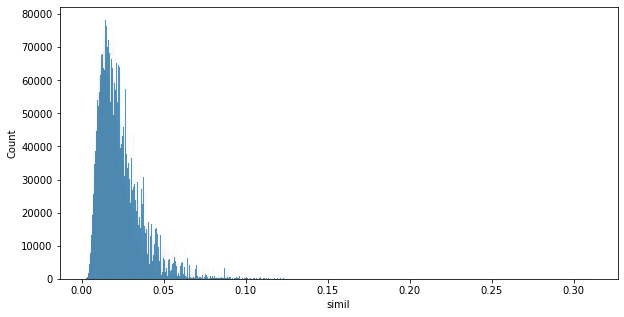

In [282]:
c = (
    (pdf['len_b'] != pdf['len_common']) &
    (pdf['len_a'] > 10) &
    (pdf['len_b'] > 10)
)

sns.histplot(data=pdf[c], x='simil')

<AxesSubplot:xlabel='len_common', ylabel='simil'>

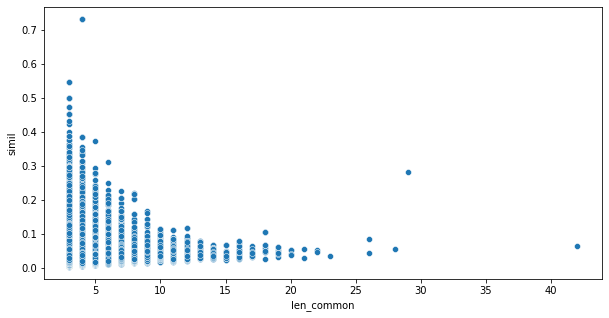

In [283]:
c = (
    (pdf['len_b'] != pdf['len_common']) &
    (pdf['len_common'] > 2)
)

sns.scatterplot(data=pdf[c], x='len_common', y='simil')

<AxesSubplot:xlabel='len_b', ylabel='simil'>

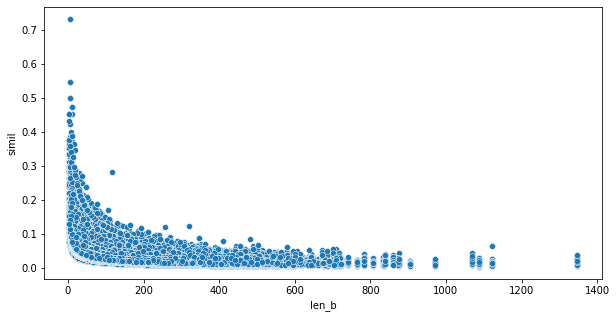

In [284]:
c = (
    (pdf['len_b'] != pdf['len_common']) &
    (pdf['len_common'] > 2)
)

sns.scatterplot(data=pdf[c], x='len_b', y='simil')

<AxesSubplot:xlabel='len_a', ylabel='simil'>

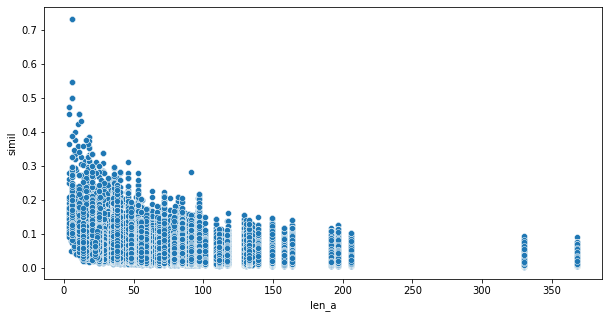

In [285]:
c = (
    (pdf['len_b'] != pdf['len_common']) &
    (pdf['len_common'] > 2)
)

sns.scatterplot(data=pdf[c], x='len_a', y='simil')

<AxesSubplot:xlabel='len_a', ylabel='len_common'>

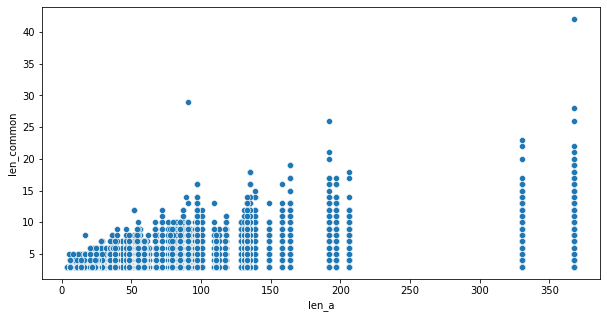

In [286]:
c = (
    (pdf['len_b'] != pdf['len_common']) &
    (pdf['len_common'] > 2)
)

sns.scatterplot(data=pdf[c], x='len_a', y='len_common')

<AxesSubplot:xlabel='krank', ylabel='simil'>

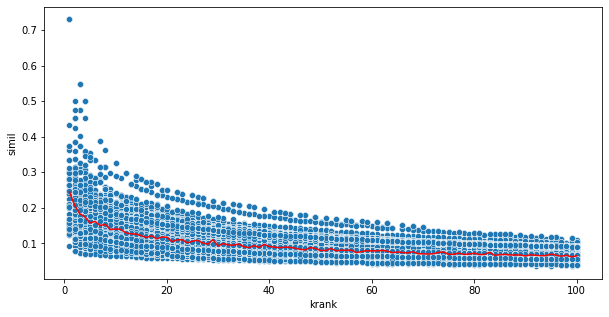

In [287]:
c = (
    (pdf['krank'] <= 100) &
    (pdf['len_b'] != pdf['len_common']) &
    (pdf['len_common'] > 2)
)

sns.scatterplot(data=pdf[c], x='krank', y='simil')
pdf[c].groupby('krank')['simil'].mean().plot(c='r')

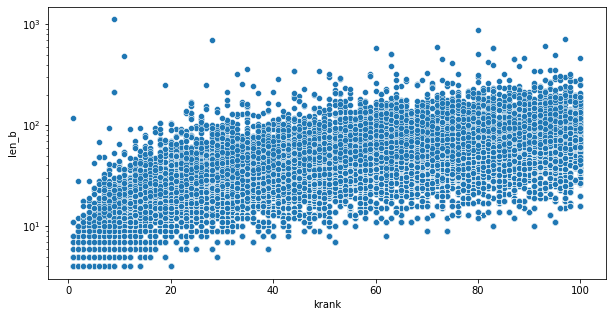

In [293]:
c = (
    (pdf['krank'] <= 100) &
    (pdf['len_b'] != pdf['len_common']) &
    (pdf['len_common'] > 2)
)

sns.scatterplot(data=pdf[c], x='krank', y='len_b')
plt.yscale('log')

<AxesSubplot:xlabel='krank', ylabel='len_common'>

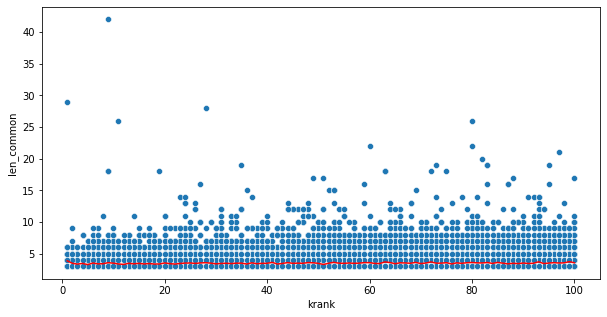

In [288]:
c = (
    (pdf['krank'] <= 100) &
    (pdf['len_b'] != pdf['len_common']) &
    (pdf['len_common'] > 2)
)

sns.scatterplot(data=pdf[c], x='krank', y='len_common')
pdf[c].groupby('krank')['len_common'].mean().plot(c='r')

In [215]:
rv = cust_item_lookup[random_ids[0]]
similarities = []
for nid in np.random.choice(cust_items.index, 10000):
    u = cust_item_lookup[nid]
    r = {
        'simil': cosince_simil(rv, u),
        'len_b': len(u),
        'len_common': len(rv & u),
        'len_a': len(rv),
        'b': nid,
        'a': random_ids[0]
    }
    similarities.append(r)

In [216]:
_ = pd.DataFrame(similarities)

<AxesSubplot:xlabel='simil', ylabel='Count'>

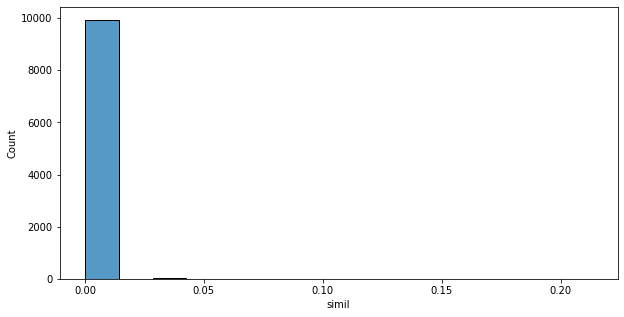

In [217]:
sns.histplot(data=_, x='simil')

In [65]:
_ = list(result[random_ids[24]].values())

In [ ]:
# 1 0 1 1 0
# l2-norm 1/sqrt(1+0+1+1+0)
# l1-norm 1/(1+0+1+1+0)

[Text(0.5, 1.0, '9946542fd345cc7f0f1e675da1ca8e93440f05ac6005f747f43a3f3754997169; #items: 6; #neighbours 6102')]

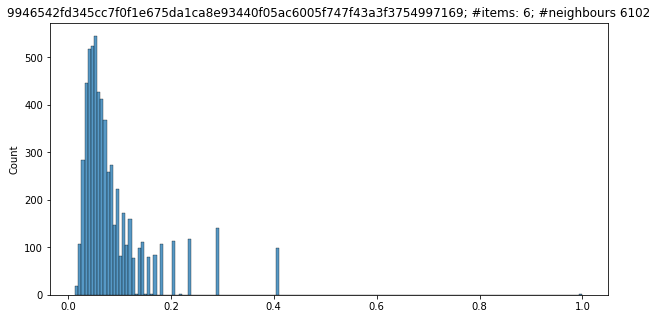

In [70]:
cid = random_ids[24]
similarities = result[cid]
_ = list(similarities.values())

fig, ax = plt.subplots(1, 1)
sns.histplot(_, ax=ax)

ax.set(title=f'{cid}; #items: {len(cust_item_lookup[cid])}; #neighbours {len(_)}')

[Text(0.5, 1.0, 'a7d78259597df833a6315e5e7311c5942e05fca6f972b8f5bd6895bd9b3e505e; #items: 3; #neighbours 7045')]

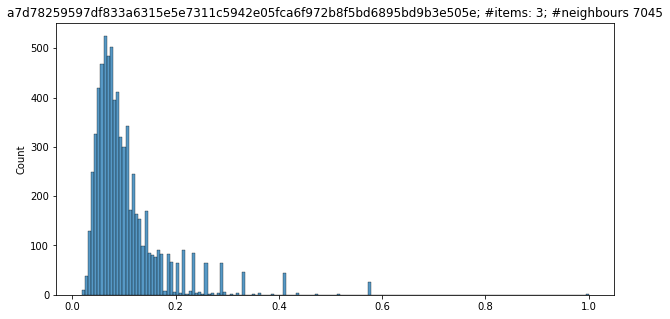

In [72]:
cid = random_ids[33]
similarities = result[cid]
_ = list(similarities.values())

fig, ax = plt.subplots(1, 1)
sns.histplot(_, ax=ax)

ax.set(title=f'{cid}; #items: {len(cust_item_lookup[cid])}; #neighbours {len(_)}')

[Text(0.5, 1.0, '95a893116f980f1b72b3272b0bf8fb4061029bad510f8cfa2fb4ee61f5ba6a1f; #items: 12; #neighbours 27811')]

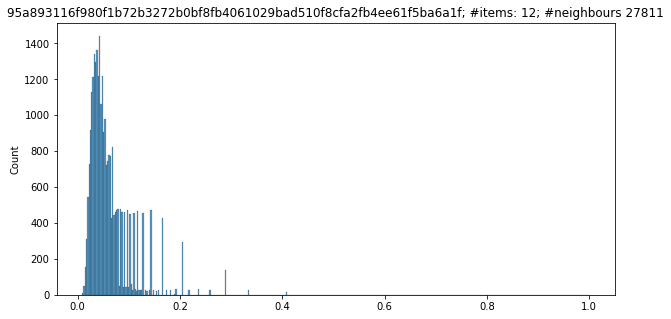

In [74]:
cid = random_ids[99]
similarities = result[cid]
_ = list(similarities.values())

fig, ax = plt.subplots(1, 1)
sns.histplot(_, ax=ax)

ax.set(title=f'{cid}; #items: {len(cust_item_lookup[cid])}; #neighbours {len(_)}')

[Text(0.5, 1.0, 'a440b28aaa9b202daca12498204966268394e51e04af7c2745201262b72ad416; #items: 1; #neighbours 142')]

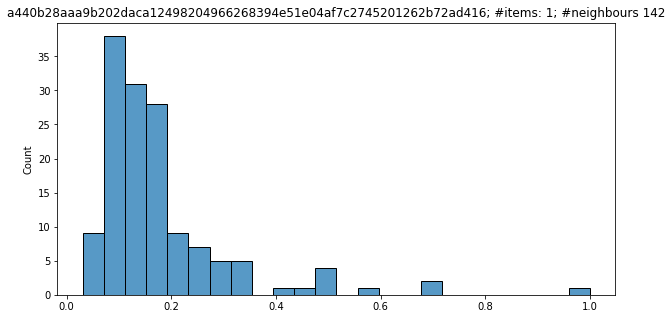

In [75]:
cid = random_ids[42]
similarities = result[cid]
_ = list(similarities.values())

fig, ax = plt.subplots(1, 1)
sns.histplot(_, ax=ax)

ax.set(title=f'{cid}; #items: {len(cust_item_lookup[cid])}; #neighbours {len(_)}')

[Text(0.5, 1.0, '575b6bb74047cd2e795aca55ab0084a2a39b5ae43d02c36c80707d1535a00c94; #items: 34; #neighbours 37354')]

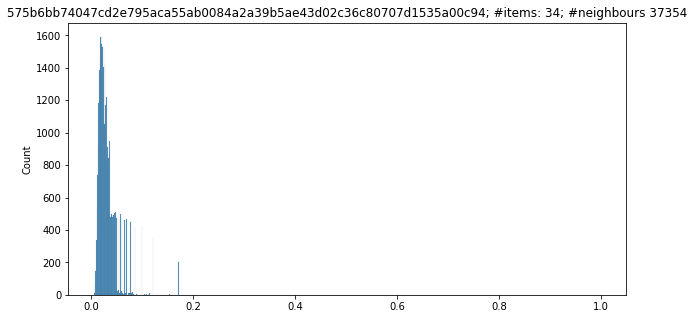

In [77]:
cid = random_ids[2]
similarities = result[cid]
_ = list(similarities.values())

fig, ax = plt.subplots(1, 1)
sns.histplot(_, ax=ax)

ax.set(title=f'{cid}; #items: {len(cust_item_lookup[cid])}; #neighbours {len(_)}')

In [93]:
cid = random_ids[2]
similarities = result[cid]

s = pd.Series(similarities).reset_index()

In [98]:
s['item_cnt'] = s['index'].apply(lambda cid: len(cust_item_lookup[cid]))

In [104]:
s[s['item_cnt'] > 5].sort_values(0, ascending=False).head(10)

index     0  item_cnt
23225  575b6bb74047cd2e795aca55ab0084a2a39b5ae43d02c3... 1.000        34
20144  4c874539db8f799271fa9c4bd447c7552690428197f846... 0.140         6
35949  35bdece3220f9f1ec092b154db52bce79f4748c5656943... 0.140         6
4633   de25ec811e845dd4338ee732ad78e17d23450e4bb10298... 0.140         6
15909  d01e7bf362629ed4c729dcf15fd6744f364c87ec775277... 0.130         7
14775  d723564f9ad8cea82b31c3ffa7a1c09b0e778d8c2a75ad... 0.130         7
35971  ad4c4920a7708e141cff90e70bfd3ece156216773e54da... 0.121         8
13230  af9062d34fda465b13b23cb52c92150b4375df9ddd5130... 0.121         8
21945  7cd5bca59e759d598260d53858fa111cd42da4ad094294... 0.121         8
3717   cca66b096f68d5f4723b84b79968b0e776305d1e4ab200... 0.121         8

In [89]:
s.sort_values(ascending=False)[:5]

575b6bb74047cd2e795aca55ab0084a2a39b5ae43d02c36c80707d1535a00c94   1.000
756c5b812301aadee4b1331e62ec5a018e11423709f2a046461b59dccdfa1aed   0.171
5296ce9f4cd8baa72fa5b9bea01f199e53220915ff9f3d14ce476a3a68b3a766   0.171
be070ee0b3b604897e66a653dba614a3dff3441a5f37c835b2f870ad0c26cd11   0.171
8486175382cefbb63f96b723dde0af5989a5cd62a058f3b4343dbb9923538204   0.171
dtype: float64

In [90]:
cust_item_lookup['756c5b812301aadee4b1331e62ec5a018e11423709f2a046461b59dccdfa1aed']

{'0866218009'}

In [92]:
cust_item_lookup[random_ids[2]]

{'0278811006',
 '0359043008',
 '0406724003',
 '0492897002',
 '0598755002',
 '0708489001',
 '0711053003',
 '0737610001',
 '0754792001',
 '0764355004',
 '0767311006',
 '0770958003',
 '0784432009',
 '0790686005',
 '0799365002',
 '0818059004',
 '0821398001',
 '0822115004',
 '0824764012',
 '0834021005',
 '0834758001',
 '0849182001',
 '0849217006',
 '0857766001',
 '0860742001',
 '0866178002',
 '0866218009',
 '0871002002',
 '0871568003',
 '0872618001',
 '0878510002',
 '0880839001',
 '0900673002',
 '0902229003'}

[Text(0.5, 1.0, '7d59603876a749bc9a588f6a89766bc9cc46308c1605de12742bd74f59844b5b; #items: 20; #neighbours 26513')]

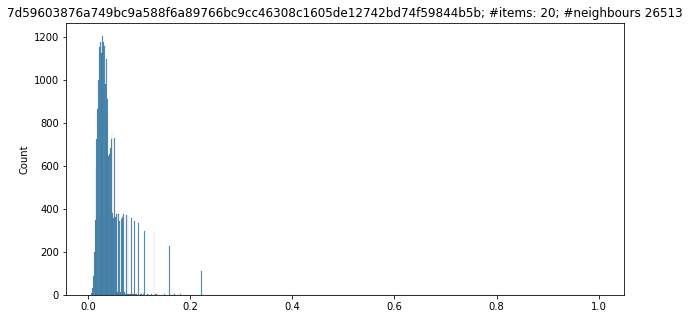

In [78]:
cid = random_ids[3]
similarities = result[cid]
_ = list(similarities.values())

fig, ax = plt.subplots(1, 1)
sns.histplot(_, ax=ax)

ax.set(title=f'{cid}; #items: {len(cust_item_lookup[cid])}; #neighbours {len(_)}')

[Text(0.5, 1.0, 'a5ea647ff1d8dd7587d7b39ba5d2d7cd2b0cb573d10b31e7f9472a8ccc82fd24; #items: 9; #neighbours 8267')]

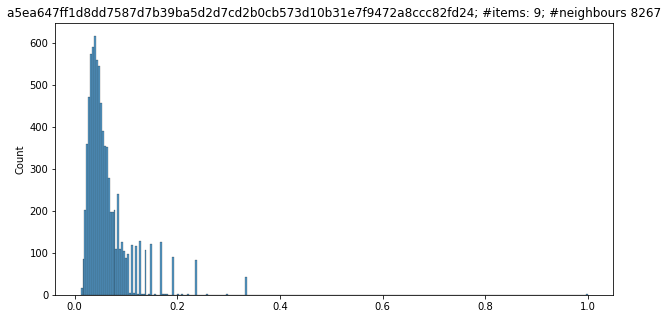

In [84]:
cid = random_ids[7]
similarities = result[cid]
_ = list(similarities.values())

fig, ax = plt.subplots(1, 1)
sns.histplot(_, ax=ax)

ax.set(title=f'{cid}; #items: {len(cust_item_lookup[cid])}; #neighbours {len(_)}')